In [1]:
# import libraries:
import pandas as pd
pd.set_option('display.max_columns', None) # To show all the columns
import numpy as np
import re
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [16, 18]
plt.rcParams['figure.dpi'] = 200
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import random
import xgboost as xg
from sklearn.metrics import mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import seaborn as sb
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo
from factor_analyzer import FactorAnalyzer
from scipy.stats import chi2_contingency 
from sklearn.model_selection import *
from scipy.stats import uniform, randint

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
# check the shape
print(train.shape)
print(test.shape)

(1460, 81)
(1459, 80)


In [4]:
# assign X as DataFrame of features and y as a Series of the outcome variable
X = train.drop('SalePrice', 1)
y = train.SalePrice

In [5]:
X.dtypes
test.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MiscVal            int64
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
Length: 80, dtype: object

In [6]:
X['MSSubClass'] = X['MSSubClass'].apply(str)
test['MSSubClass'] = test['MSSubClass'].apply(str)

In [7]:
# lets's factorize all ordinal features
X[['OverallQual', 'OverallCond']] = X[['OverallQual', 'OverallCond']].astype('category')
test[['OverallQual', 'OverallCond']] = test[['OverallQual', 'OverallCond']].astype('category')
X[['OverallQual', 'OverallCond']] = X[['OverallQual', 'OverallCond']].apply(lambda x: pd.factorize(x, sort=True)[0])
test[['OverallQual', 'OverallCond']] = test[['OverallQual', 'OverallCond']].apply(lambda x: pd.factorize(x, sort=True)[0])
##############################################################
X[['ExterQual', 'ExterCond', 'HeatingQC']] = X[['ExterQual', 'ExterCond', 'HeatingQC']].replace({'Po':0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4 })
test[['ExterQual', 'ExterCond', 'HeatingQC']] = test[['ExterQual', 'ExterCond', 'HeatingQC']].replace({'Po':0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4 })
X[['ExterQual', 'ExterCond', 'HeatingQC']] = X[['ExterQual', 'ExterCond', 'HeatingQC']].astype('category')
test[['ExterQual', 'ExterCond', 'HeatingQC']] = test[['ExterQual', 'ExterCond', 'HeatingQC']].astype('category')
X[['ExterQual', 'ExterCond', 'HeatingQC']] = X[['ExterQual', 'ExterCond', 'HeatingQC']].apply(lambda x: pd.factorize(x, sort=True)[0])
test[['ExterQual', 'ExterCond', 'HeatingQC']] = test[['ExterQual', 'ExterCond', 'HeatingQC']].apply(lambda x: pd.factorize(x, sort=True)[0])

In [8]:
# For this dataset, NAs are meaningfull for many categorical feautures. Replace NaN with 'NA' for next work.
for col in X.columns:
    if (X[col].dtypes == 'object'):
        X[col] = X[col].fillna('NA')
for col in test.columns:
    if (test[col].dtypes == 'object'):
        test[col] = test[col].fillna('NA')

In [9]:
X.loc[:,'BsmtQual'] = X.loc[:,'BsmtQual'].replace({'NA':0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4 })
test.loc[:, 'BsmtQual'] = test.loc[:, 'BsmtQual'].replace({'NA':0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4 })
X.loc[:, 'BsmtQual'] = X.loc[:, 'BsmtQual'].astype('category')
test.loc[:, 'BsmtQual'] = test.loc[:, 'BsmtQual'].astype('category')
X.loc[:, 'BsmtQual'] = pd.factorize(X.loc[:, 'BsmtQual'], sort=True)[0]
test.loc[:, 'BsmtQual'] = pd.factorize(test.loc[:, 'BsmtQual'], sort=True)[0]
##########################################################################
X.loc[:,'BsmtCond'] = X.loc[:,'BsmtCond'].replace({'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4 })
test.loc[:, 'BsmtCond'] = test.loc[:, 'BsmtCond'].replace({'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4 })
X.loc[:, 'BsmtCond'] = X.loc[:, 'BsmtCond'].astype('category')
test.loc[:, 'BsmtCond'] = test.loc[:, 'BsmtCond'].astype('category')
X.loc[:, 'BsmtCond'] = pd.factorize(X.loc[:, 'BsmtCond'], sort=True)[0]
test.loc[:, 'BsmtCond'] = pd.factorize(test.loc[:, 'BsmtCond'], sort=True)[0]
############################################################################
X.loc[:,'BsmtExposure'] = X.loc[:,'BsmtExposure'].replace({'No':0, 'NA':0, 'Mn':1, 'Av':2, 'Gd':3})
test.loc[:, 'BsmtExposure'] = test.loc[:, 'BsmtExposure'].replace({'No':0, 'NA':0, 'Mn':1, 'Av':2, 'Gd':3})
X.loc[:, 'BsmtExposure'] = X.loc[:, 'BsmtExposure'].astype('category')
test.loc[:, 'BsmtExposure'] = test.loc[:, 'BsmtExposure'].astype('category')
X.loc[:, 'BsmtExposure'] = pd.factorize(X.loc[:, 'BsmtExposure'], sort=True)[0]
test.loc[:, 'BsmtExposure'] = pd.factorize(test.loc[:, 'BsmtExposure'], sort=True)[0]
############################################################################
X[['BsmtFinType1', 'BsmtFinType2']] = X[['BsmtFinType1', 'BsmtFinType2']].replace({'NA':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6})
test[['BsmtFinType1', 'BsmtFinType2']] = test[['BsmtFinType1', 'BsmtFinType2']].replace({'NA':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6})
X[['BsmtFinType1', 'BsmtFinType2']] = X[['BsmtFinType1', 'BsmtFinType2']].astype('category')
test[['BsmtFinType1', 'BsmtFinType2']] = test[['BsmtFinType1', 'BsmtFinType2']].astype('category')
X[['BsmtFinType1', 'BsmtFinType2']] = X[['BsmtFinType1', 'BsmtFinType2']].apply(lambda x: pd.factorize(x, sort=True)[0])
test[['BsmtFinType1', 'BsmtFinType2']] = test[['BsmtFinType1', 'BsmtFinType2']].apply(lambda x: pd.factorize(x, sort=True)[0])
############################################################################
X.loc[:,'KitchenQual'] = X.loc[:,'KitchenQual'].replace({'NA':0, 'Fa':0, 'TA':1, 'Gd':2, 'Ex':3})
test.loc[:, 'KitchenQual'] = test.loc[:, 'KitchenQual'].replace({'NA':0, 'Fa':0, 'TA':1, 'Gd':2, 'Ex':3})
X.loc[:, 'KitchenQual'] = X.loc[:, 'KitchenQual'].astype('category')
test.loc[:, 'KitchenQual'] = test.loc[:, 'KitchenQual'].astype('category')
X.loc[:, 'KitchenQual'] = pd.factorize(X.loc[:, 'KitchenQual'], sort=True)[0]
test.loc[:, 'KitchenQual'] = pd.factorize(test.loc[:, 'KitchenQual'], sort=True)[0]
############################################################################
X.loc[:,'Functional'] = X.loc[:,'Functional'].replace({'NA':0, 'Sev':0, 'Maj2':1, 'Maj1':2, 'Mod':3, 'Min2':4, 'Min1':5, 'Typ':6})
test.loc[:, 'Functional'] = test.loc[:, 'Functional'].replace({'NA':0, 'Sev':0, 'Maj2':1, 'Maj1':2, 'Mod':3, 'Min2':4, 'Min1':5, 'Typ':6})
X.loc[:, 'Functional'] = X.loc[:, 'Functional'].astype('category')
test.loc[:, 'Functional'] = test.loc[:, 'Functional'].astype('category')
X.loc[:, 'Functional'] = pd.factorize(X.loc[:, 'Functional'], sort=True)[0]
test.loc[:, 'Functional'] = pd.factorize(test.loc[:, 'Functional'], sort=True)[0]
############################################################################
X.loc[:,'FireplaceQu'] = X.loc[:,'FireplaceQu'].replace({'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
test.loc[:, 'FireplaceQu'] = test.loc[:, 'FireplaceQu'].replace({'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
X.loc[:, 'FireplaceQu'] = X.loc[:, 'FireplaceQu'].astype('category')
test.loc[:, 'FireplaceQu'] = test.loc[:, 'FireplaceQu'].astype('category')
X.loc[:, 'FireplaceQu'] = pd.factorize(X.loc[:, 'FireplaceQu'], sort=True)[0]
test.loc[:, 'FireplaceQu'] = pd.factorize(test.loc[:, 'FireplaceQu'], sort=True)[0]
############################################################################
X.loc[:,'GarageFinish'] = X.loc[:,'GarageFinish'].replace({'NA':0, 'Unf':1, 'RFn':2, 'Fin':3})
test.loc[:, 'GarageFinish'] = test.loc[:, 'GarageFinish'].replace({'NA':0, 'Unf':1, 'RFn':2, 'Fin':3})
X.loc[:, 'GarageFinish'] = X.loc[:, 'GarageFinish'].astype('category')
test.loc[:, 'GarageFinish'] = test.loc[:, 'GarageFinish'].astype('category')
X.loc[:, 'GarageFinish'] = pd.factorize(X.loc[:, 'GarageFinish'], sort=True)[0]
test.loc[:, 'GarageFinish'] = pd.factorize(test.loc[:, 'GarageFinish'], sort=True)[0]
############################################################################
X[['GarageQual', 'GarageCond']] = X[['GarageQual', 'GarageCond']].replace({'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
test[['GarageQual', 'GarageCond']] = test[['GarageQual', 'GarageCond']].replace({'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
X[['GarageQual', 'GarageCond']] = X[['GarageQual', 'GarageCond']].astype('category')
test[['GarageQual', 'GarageCond']] = test[['GarageQual', 'GarageCond']].astype('category')
X[['GarageQual', 'GarageCond']] = X[['GarageQual', 'GarageCond']].apply(lambda x: pd.factorize(x, sort=True)[0])
test[['GarageQual', 'GarageCond']] = test[['GarageQual', 'GarageCond']].apply(lambda x: pd.factorize(x, sort=True)[0])
############################################################################
X.loc[:,'PoolQC'] = X.loc[:,'Fence'].replace({'NA':0, 'Fa':0, 'Gd':1, 'Ex':2})
test.loc[:, 'PoolQC'] = test.loc[:, 'Fence'].replace({'NA':0, 'Fa':0, 'Gd':1, 'Ex':2})
X.loc[:, 'PoolQC'] = X.loc[:, 'Fence'].astype('category')
test.loc[:, 'PoolQC'] = test.loc[:, 'Fence'].astype('category')
X.loc[:, 'PoolQC'] = pd.factorize(X.loc[:, 'Fence'], sort=True)[0]
test.loc[:, 'PoolQC'] = pd.factorize(test.loc[:, 'Fence'], sort=True)[0]
############################################################################
X.loc[:,'Fence'] = X.loc[:,'Fence'].replace({'NA':0, 'MnWw':1, 'GdWo':2, 'MnPrv':3, 'GdPrv':4})
test.loc[:, 'Fence'] = test.loc[:, 'Fence'].replace({'NA':0, 'MnWw':1, 'GdWo':2, 'MnPrv':3, 'GdPrv':4})
X.loc[:, 'Fence'] = X.loc[:, 'Fence'].astype('category')
test.loc[:, 'Fence'] = test.loc[:, 'Fence'].astype('category')
X.loc[:, 'Fence'] = pd.factorize(X.loc[:, 'Fence'], sort=True)[0]
test.loc[:, 'Fence'] = pd.factorize(test.loc[:, 'Fence'], sort=True)[0]

In [10]:
cat = X[['OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'HeatingQC', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence']]
cat_test = test[['OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'HeatingQC', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence']]

In [11]:
# Adequacy Test
# Bartlett’s Test
chi_square_value,p_value=calculate_bartlett_sphericity(cat)
print(chi_square_value, p_value)
# Kaiser-Meyer-Olkin
kmo_all,kmo_model=calculate_kmo(cat)
print(kmo_model)
### We can proceed factor analysis

14551.875955620799 0.0
0.772531614906892


In [12]:
fa = FactorAnalyzer()
fa.fit(cat)
eigen_values, vectors = fa.get_eigenvalues()

[4.9338923  2.21453742 1.66285259 1.43863168 1.26578826 1.01964098
 0.89644692 0.81907233 0.73207138 0.6183135  0.59897734 0.53965155
 0.4140486  0.29513874 0.24503476 0.21848753 0.04713239 0.04028174]


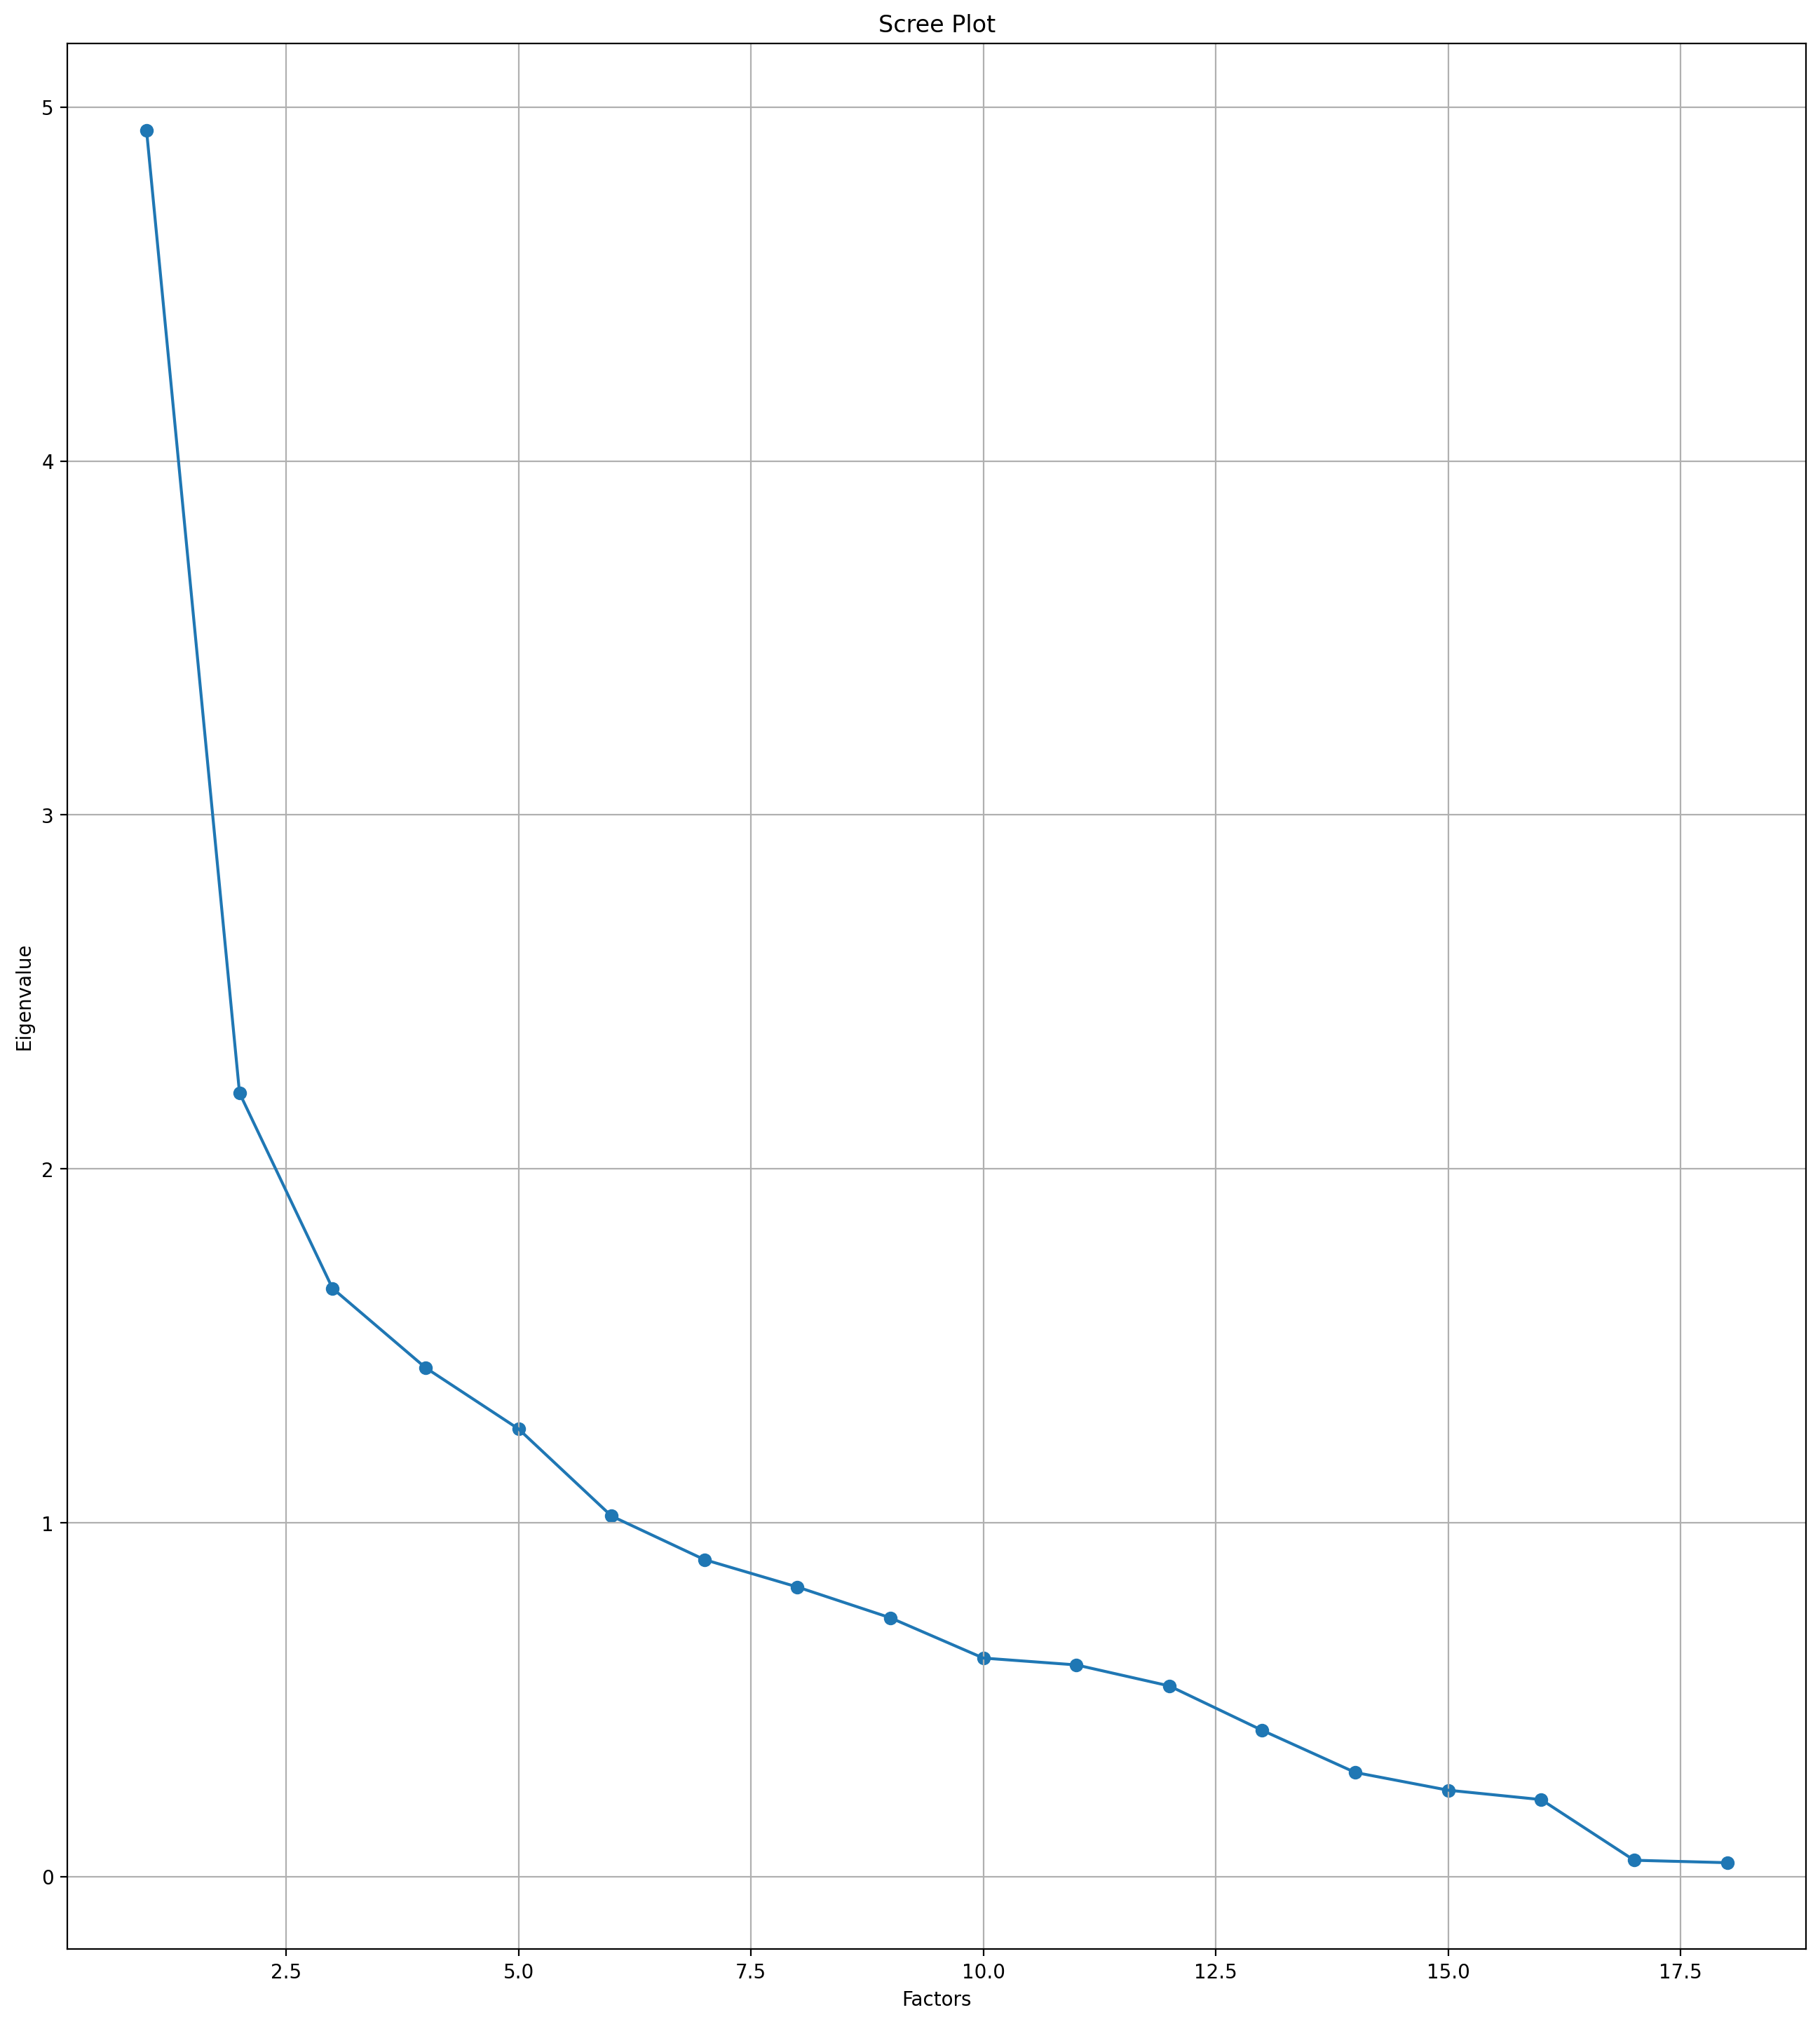

In [13]:
print(eigen_values)
plt.scatter(range(1,cat.shape[1]+1),eigen_values)
plt.plot(range(1,cat.shape[1]+1),eigen_values)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

In [14]:
fa = FactorAnalyzer()
fa.set_params(n_factors= 6, rotation='varimax')
fa.fit(cat)
print(pd.DataFrame(fa.loadings_,index=cat.columns))
print(pd.DataFrame(fa.get_factor_variance(),index=['Variance','Proportional Var','Cumulative Var']))

                     0         1         2         3         4         5
OverallQual   0.837605  0.126141  0.044469  0.081926 -0.004635  0.130860
OverallCond  -0.107240 -0.025096 -0.102219  0.032857  0.782168 -0.054932
ExterQual     0.846226  0.049100  0.122608  0.002984 -0.020928  0.089905
ExterCond     0.014464  0.055985 -0.035551  0.059715  0.498853  0.014644
HeatingQC     0.572739  0.035341  0.113586  0.040267  0.076732  0.035901
BsmtQual      0.671750  0.046007  0.092512  0.410975 -0.146406  0.297523
BsmtCond      0.203341  0.035055 -0.003635  0.955610  0.168063  0.111058
BsmtExposure  0.212272  0.000127  0.035008  0.029479 -0.022093  0.591294
BsmtFinType1  0.204965  0.077598  0.007019  0.207679  0.052191  0.456583
BsmtFinType2 -0.079283  0.043500 -0.125530  0.219882  0.087622  0.155646
KitchenQual   0.792277  0.065318  0.036830 -0.014435  0.099097  0.131585
Functional    0.116993  0.045237  0.034657  0.079611  0.160480  0.076130
FireplaceQu   0.449705  0.146112  0.006286  0.00914

In [15]:
factor_names = ['Quality', 'Garage', 'Pool and Fence (-)', 'Basement', 'Condition', 'Exposure']

In [16]:
cat_f = pd.DataFrame(fa.transform(cat), columns = factor_names)
cat_test_f = pd.DataFrame(fa.transform(cat_test), columns = factor_names)

In [17]:
#################################################################
# nominal features
################################################################

In [18]:
obj = X.select_dtypes(include = 'object')
obj_test = test.select_dtypes(include = 'object')

In [19]:
for i in range(len(obj.columns)):
    for j in range(len(obj.columns)):
        if (obj.columns[i] != obj.columns[j]):
            cont = pd.crosstab(obj[obj.columns[i]], obj[obj.columns[j]])
            chi2, p, dof, expected = stats.chi2_contingency(cont)
            if p > 0.05:
                print(obj.columns[i], '-', obj.columns[j], ':', p)

MSSubClass - Utilities : 0.9999667129585035
MSZoning - Utilities : 0.9917472273613425
MSZoning - RoofMatl : 0.9999974089619902
MSZoning - MiscFeature : 0.5581984295881148
Street - Alley : 0.8185354845896631
Street - LotShape : 0.19796136612247495
Street - LotConfig : 0.842880187056049
Street - Condition2 : 0.9999995463032315
Street - HouseStyle : 0.37390013047604437
Street - RoofStyle : 0.9758161364086618
Street - RoofMatl : 0.9999968624129736
Street - Exterior1st : 0.9514721506851134
Street - Exterior2nd : 0.9721226423124726
Street - MasVnrType : 0.9517843890238364
Street - Foundation : 0.16473935985925164
Street - Heating : 0.9996604865549404
Street - CentralAir : 0.06571372309414236
Street - Electrical : 0.9492493765996777
Street - PavedDrive : 0.5356265799304165
Alley - Street : 0.8185354845896631
Alley - Utilities : 0.967288271759853
Alley - LotConfig : 0.17234103091279637
Alley - LandSlope : 0.8021520408853986
Alley - Condition2 : 0.9999989477220056
Alley - RoofMatl : 0.999962323

Electrical - Condition1 : 0.3988199436857224
Electrical - Condition2 : 0.9999999999999998
Electrical - RoofStyle : 0.9998963990854
Electrical - RoofMatl : 0.9823475984855337
Electrical - MiscFeature : 0.999999780859222
Electrical - SaleType : 0.9967579238626262
GarageType - RoofMatl : 0.9067670150787884
GarageType - MiscFeature : 0.2022134721601172
PavedDrive - Street : 0.5356265799304165
PavedDrive - Utilities : 0.9561821897857264
PavedDrive - LotConfig : 0.23366209065833954
PavedDrive - LandSlope : 0.7680303963090412
PavedDrive - RoofMatl : 0.9997667327837817
PavedDrive - MiscFeature : 0.08780749248826364
MiscFeature - MSZoning : 0.5581984295881152
MiscFeature - Alley : 0.747349461250158
MiscFeature - LotShape : 0.7905515599782561
MiscFeature - LandContour : 0.9996770470104955
MiscFeature - Utilities : 0.999817710057007
MiscFeature - LotConfig : 0.8857635536880711
MiscFeature - LandSlope : 0.5903757921023032
MiscFeature - Neighborhood : 0.8894450712617853
MiscFeature - HouseStyle : 0

In [20]:
#########################################################################
pd.crosstab(obj.MSSubClass, obj.Utilities)
X.Utilities.value_counts()
# Feature Utilities is not useful, so we will drop it.
X = X.drop('Utilities', axis = 1)
test = test.drop('Utilities', axis = 1)
obj = obj.drop('Utilities', axis = 1)
obj_test = obj_test.drop('Utilities', axis = 1)
########################################################################
pd.crosstab(obj.MSZoning, obj.RoofMatl)
# For the majority of Zones RoofMatl is predictable. So, let's drop RoofMatl
X = X.drop('RoofMatl', axis = 1)
test = test.drop('RoofMatl', axis = 1)
obj = obj.drop('RoofMatl', axis = 1)
obj_test = obj_test.drop('RoofMatl', axis = 1)
####################################################
pd.crosstab(obj.LotShape, obj.Condition2)
X.Condition2.value_counts()
X = X.drop('Condition2', axis = 1)
test = test.drop('Condition2', axis = 1)
obj = obj.drop('Condition2', axis = 1)
obj_test = obj_test.drop('Condition2', axis = 1)

In [21]:
nom_col = obj.columns
nom_col

Index(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'BldgType',
       'HouseStyle', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'Foundation', 'Heating', 'CentralAir', 'Electrical', 'GarageType',
       'PavedDrive', 'MiscFeature', 'SaleType', 'SaleCondition'],
      dtype='object')

In [22]:
# Check the missing values for the rest of objects:
for col in X[nom_col].columns:
    sum = 0
    for i in range(len(X)):
        if X.loc[i, col] == 'NA':
            sum += 1
    if (sum > 0):
        print(col, sum)
# Alley, GarageType and MiscFeauture are ok.

Alley 1369
MasVnrType 8
Electrical 1
GarageType 81
MiscFeature 1406


In [23]:
X.Electrical.value_counts()
# replace the observation where electrical = NA with the most frequent value
X.Electrical.value_counts()
for i in range(len(X)):
    if (X.loc[i, 'Electrical'] == 'NA'):
        X.loc[i, 'Electrical'] = X.loc[i, 'Electrical'].replace('NA', 'SBrkr')

In [24]:
#Check test:
for col in test[nom_col].columns:
    sum = 0
    for i in range(len(test)):
        if test.loc[i, col] == 'NA':
            sum += 1
    if (sum > 0):
        print(col, sum)
# Alley, GarageType and MiscGeauture are ok.

MSZoning 4
Alley 1352
Exterior1st 1
Exterior2nd 1
MasVnrType 16
GarageType 76
MiscFeature 1408
SaleType 1


In [25]:
X.MSZoning.value_counts()
pd.crosstab(X.MSSubClass, X.MSZoning)
# We may see, that there is high possibility that MSSubClass 20, 30  have MSZoning RL and MSSubClass 70 has almost the same chance for RL and RM.
types = ['RL', 'RM']
for i in range(len(test)):
    if (test.loc[i, 'MSZoning'] == 'NA') &  ((test.loc[i, 'MSSubClass'] == '20')| (test.loc[i, 'MSSubClass'] == '30')):
        test.loc[i, 'MSZoning'] = test.iloc[i]['MSZoning'].replace('NA', 'RL')
    elif ((test.iloc[i].MSZoning == 'NA') and (test.iloc[i].MSSubClass == '70')):
        test.loc[i, 'MSZoning'] = test.iloc[i]['MSZoning'].replace('NA', random.choice(types))
################################################################################################################
test[test.Exterior1st == 'NA'].Neighborhood
pd.crosstab(X.Neighborhood, X.Exterior1st)
# We may see, that there is high possibility that Neighborhood Edward has Exterior1st MetalSd, VinylSd or Wd Sdng
types = ['MetalSd', 'VinylSd', 'Wd Sdng']
for i in range(len(test)):
    if (test.loc[i, 'Exterior1st'] == 'NA'):
        test.loc[i, 'Exterior1st'] = test.iloc[i]['Exterior1st'].replace('NA', random.choice(types))
################################################################################################################
test[test.Exterior2nd == 'NA'].Neighborhood
pd.crosstab(X.Neighborhood, X.Exterior2nd)
types = ['MetalSd', 'VinylSd', 'Wd Sdng']
for i in range(len(test)):
    if (test.loc[i, 'Exterior2nd'] == 'NA'):
        test.loc[i, 'Exterior2nd'] = test.iloc[i]['Exterior2nd'].replace('NA', random.choice(types))
################################################################################################################
for i in range(len(test)):
    if (test.loc[i, 'SaleType'] == 'NA'):
        test.loc[i, 'SaleType'] = test.iloc[i]['SaleType'].replace('NA', 'WD')

In [26]:
# check the MasVnrType feauture:
print(X.MasVnrType.unique())
print(test.MasVnrType.unique())
print(X[X.MasVnrType == 'NA'][['Neighborhood', 'MasVnrArea', 'MasVnrType']])
print(test[test.MasVnrType == 'NA'][['Neighborhood', 'MasVnrArea', 'MasVnrType']])


['BrkFace' 'None' 'Stone' 'BrkCmn' 'NA']
['None' 'BrkFace' 'Stone' 'BrkCmn' 'NA']
     Neighborhood  MasVnrArea MasVnrType
234       Gilbert         NaN         NA
529       Crawfor         NaN         NA
650       Somerst         NaN         NA
936       SawyerW         NaN         NA
973       Somerst         NaN         NA
977       Somerst         NaN         NA
1243      NridgHt         NaN         NA
1278      CollgCr         NaN         NA
     Neighborhood  MasVnrArea MasVnrType
231       Gilbert         NaN         NA
246       Somerst         NaN         NA
422       CollgCr         NaN         NA
532       Gilbert         NaN         NA
544       Somerst         NaN         NA
581       Somerst         NaN         NA
851       Gilbert         NaN         NA
865       Gilbert         NaN         NA
880       Somerst         NaN         NA
889       Somerst         NaN         NA
908       Somerst         NaN         NA
1132       Timber         NaN         NA
1150      Mitche

In [27]:
# replace the rest NA values with the most frequent value for each neighborhood
glob_mastype = pd.concat([X[X.MasVnrType != 'NA'][['Neighborhood', 'MasVnrArea', 'MasVnrType']],test[(test.MasVnrType != 'NA')][['Neighborhood', 'MasVnrArea', 'MasVnrType' ]]])
glob_mastype['Mode'] = glob_mastype.groupby('Neighborhood')['MasVnrType'].transform(lambda x: x.value_counts().index[0])
lst = ['Gilbert', 'Somerst', 'Crawfor', 'SawyerW', 'NridgHt', 'CollgCr']
#pd.set_option("display.max_rows", None)
glob_mastype.groupby('Neighborhood').MasVnrType.value_counts()

Neighborhood  MasVnrType
Blmngtn       BrkFace       27
              None           1
Blueste       None          10
BrDale        BrkFace       29
              None           1
                            ..
Timber        BrkFace       35
              None          24
              Stone         12
Veenker       None          15
              BrkFace        9
Name: MasVnrType, Length: 71, dtype: int64

In [28]:
# We may see, that for Timber and Mitchel BrkFace is more popular than stone. Replace missing values at these Neighborhoods with BrkFace.
# As for NridgHt and Somerst, the proportion for BrkFace and Stone is almost equal. So, replace missing values at these Neighborhoods with random value.
types = ['Stone', 'BrkFace']

for i in range(len(test)):
    if ((test.loc[i, 'Neighborhood'] == 'Timber') & (test.loc[i, 'MasVnrType'] == 'NA')):
        test.loc[i, 'MasVnrType'] = test.loc[i, 'MasVnrType'].replace('NA', 'BrkFace')
    elif ((test.loc[i, 'Neighborhood'] == 'NridgHt') & (test.loc[i, 'MasVnrType'] == 'NA')):
        test.loc[i, 'MasVnrType'] = test.loc[i, 'MasVnrType'].replace('NA', random.choice(types))
    elif ((test.loc[i, 'Neighborhood'] != 'NridgHt')) & (test.loc[i, 'MasVnrType'] == 'NA'):
         test.loc[i, 'MasVnrType'] = test.loc[i, 'MasVnrType'].replace('NA', 'None')

for i in range(len(X)):
    if ((X.loc[i, 'Neighborhood'] == 'NridgHt')) & (X.loc[i, 'MasVnrType'] == 'NA'):
        X.loc[i, 'MasVnrType'] = X.loc[i, 'MasVnrType'].replace('NA', random.choice(types))
    elif ((X.loc[i, 'Neighborhood'] != 'NridgHt')) & (X.loc[i, 'MasVnrType'] == 'NA'):
        X.loc[i, 'MasVnrType'] = X.loc[i, 'MasVnrType'].replace('NA', 'None')
#####################################################################################################################


In [29]:
for col in X[nom_col].columns:
    sum = 0
    for i in range(len(X)):
        if X.loc[i, col] == 'NA':
            sum += 1
    if (sum > 0):
        print(col, sum)
# Alley, GarageType and MiscFeauture are ok.
for col in test[nom_col].columns:
    sum = 0
    for i in range(len(test)):
        if test.loc[i, col] == 'NA':
            sum += 1
    if (sum > 0):
        print(col, sum)

Alley 1369
GarageType 81
MiscFeature 1406
Alley 1352
GarageType 76
MiscFeature 1408


In [30]:
#############################################################################
# We don't have NA as missing values anymore. Before encoding, we must compare levels for nominal data
##############################################################################

In [31]:
# function for compare cats in X and test
def compare_cat(df1, df2):
    diff = ['Test not in Train: ']
    diff1 = ['Train not in test: ']
    for col in df1:
        diff.extend([str(col) + '_' + str(x) for x in df2[col].unique() if x not in df1[col].unique()])
        diff1.extend([str(col) + '_' + str(x) for x in df1[col].unique() if x not in df2[col].unique()])
    return diff, diff1

In [32]:
compare_cat(X.select_dtypes(include = 'object'), test.select_dtypes(include = 'object'))

(['Test not in Train: ', 'MSSubClass_150'],
 ['Train not in test: ',
  'HouseStyle_2.5Fin',
  'Exterior1st_Stone',
  'Exterior1st_ImStucc',
  'Exterior2nd_Other',
  'Heating_OthW',
  'Heating_Floor',
  'Electrical_Mix',
  'MiscFeature_TenC'])

In [33]:
dum = pd.get_dummies(X.select_dtypes(include = 'object'), columns= X.select_dtypes(include = 'object').columns)
lst = ['MSSubClass_150']
dum = pd.concat([dum, pd.DataFrame(0, index=np.arange(len(dum)), columns = lst)], axis = 1)   
dum_test = pd.get_dummies(test.select_dtypes(include = 'object'), columns= test.select_dtypes(include = 'object').columns)
dum_test = pd.concat([dum_test, pd.DataFrame(0, index=np.arange(len(dum_test)), columns = ['HouseStyle_2.5Fin', 'Exterior1st_Stone','Exterior1st_ImStucc','Exterior2nd_Other','Heating_OthW','Heating_Floor','Electrical_Mix','MiscFeature_TenC'])], axis = 1) 
cols = dum.columns.tolist()
dum_test = dum_test[cols]

In [34]:
####################################################################
# Numerical data

In [35]:
# take a look at numerical and non-numerical features:
num = X.select_dtypes(exclude=['object', 'category'])
num_test = test.select_dtypes(exclude=['object', 'category'])

In [36]:
num.columns

Index(['Id', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'ExterQual', 'ExterCond',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces',
       'FireplaceQu', 'GarageYrBlt', 'GarageFinish', 'GarageCars',
       'GarageArea', 'GarageQual', 'GarageCond', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC',
       'Fence', 'MiscVal', 'MoSold', 'YrSold'],
      dtype='object')

In [37]:
num = num.drop(columns = ['OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'HeatingQC', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence'])
num_test = num_test.drop(columns =  ['OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'HeatingQC', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence'])

In [38]:
num.head()

,Id,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,1,65.0,8450,2003,2003,196.0,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2003.0,2,548,0,61,0,0,0,0,0,2,2008
1,2,80.0,9600,1976,1976,0.0,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,1976.0,2,460,298,0,0,0,0,0,0,5,2007
2,3,68.0,11250,2001,2002,162.0,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2001.0,2,608,0,42,0,0,0,0,0,9,2008
3,4,60.0,9550,1915,1970,0.0,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,1998.0,3,642,0,35,272,0,0,0,0,2,2006
4,5,84.0,14260,2000,2000,350.0,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,2000.0,3,836,192,84,0,0,0,0,0,12,2008


In [39]:
num_test.head()

,Id,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,1461,80.0,11622,1961,1961,0.0,468.0,144.0,270.0,882.0,896,0,0,896,0.0,0.0,1,0,2,1,5,0,1961.0,1.0,730.0,140,0,0,0,120,0,0,6,2010
1,1462,81.0,14267,1958,1958,108.0,923.0,0.0,406.0,1329.0,1329,0,0,1329,0.0,0.0,1,1,3,1,6,0,1958.0,1.0,312.0,393,36,0,0,0,0,12500,6,2010
2,1463,74.0,13830,1997,1998,0.0,791.0,0.0,137.0,928.0,928,701,0,1629,0.0,0.0,2,1,3,1,6,1,1997.0,2.0,482.0,212,34,0,0,0,0,0,3,2010
3,1464,78.0,9978,1998,1998,20.0,602.0,0.0,324.0,926.0,926,678,0,1604,0.0,0.0,2,1,3,1,7,1,1998.0,2.0,470.0,360,36,0,0,0,0,0,6,2010
4,1465,43.0,5005,1992,1992,0.0,263.0,0.0,1017.0,1280.0,1280,0,0,1280,0.0,0.0,2,0,2,1,5,0,1992.0,2.0,506.0,0,82,0,0,144,0,0,1,2010


In [40]:
num.isna().sum()

Id                 0
LotFrontage      259
LotArea            0
YearBuilt          0
YearRemodAdd       0
MasVnrArea         8
BsmtFinSF1         0
BsmtFinSF2         0
BsmtUnfSF          0
TotalBsmtSF        0
1stFlrSF           0
2ndFlrSF           0
LowQualFinSF       0
GrLivArea          0
BsmtFullBath       0
BsmtHalfBath       0
FullBath           0
HalfBath           0
BedroomAbvGr       0
KitchenAbvGr       0
TotRmsAbvGrd       0
Fireplaces         0
GarageYrBlt       81
GarageCars         0
GarageArea         0
WoodDeckSF         0
OpenPorchSF        0
EnclosedPorch      0
3SsnPorch          0
ScreenPorch        0
PoolArea           0
MiscVal            0
MoSold             0
YrSold             0
dtype: int64

              count         mean        std     min      25%     50%      75%  \
Neighborhood                                                                    
Blmngtn        17.0  2005.294118   1.311712  2003.0  2005.00  2005.0  2006.00   
Blueste         2.0  1980.000000   0.000000  1980.0  1980.00  1980.0  1980.00   
BrDale         15.0  1973.933333   6.238895  1970.0  1971.00  1972.0  1973.00   
BrkSide        48.0  1950.291667  26.456675  1916.0  1928.75  1940.0  1970.50   
ClearCr        27.0  1968.518519  19.686720  1908.0  1957.50  1968.0  1982.50   
CollgCr       148.0  1998.689189   9.358943  1969.0  1998.00  2002.0  2004.00   
Crawfor        51.0  1951.647059  26.371063  1914.0  1931.50  1942.0  1972.00   
Edwards        78.0  1967.782051  24.359668  1920.0  1951.25  1957.5  1996.00   
Gilbert        79.0  1998.683544   9.102753  1951.0  1996.50  2000.0  2004.00   
IDOTRR         29.0  1950.862069  25.628840  1906.0  1930.00  1951.0  1964.00   
MeadowV        12.0  1973.33

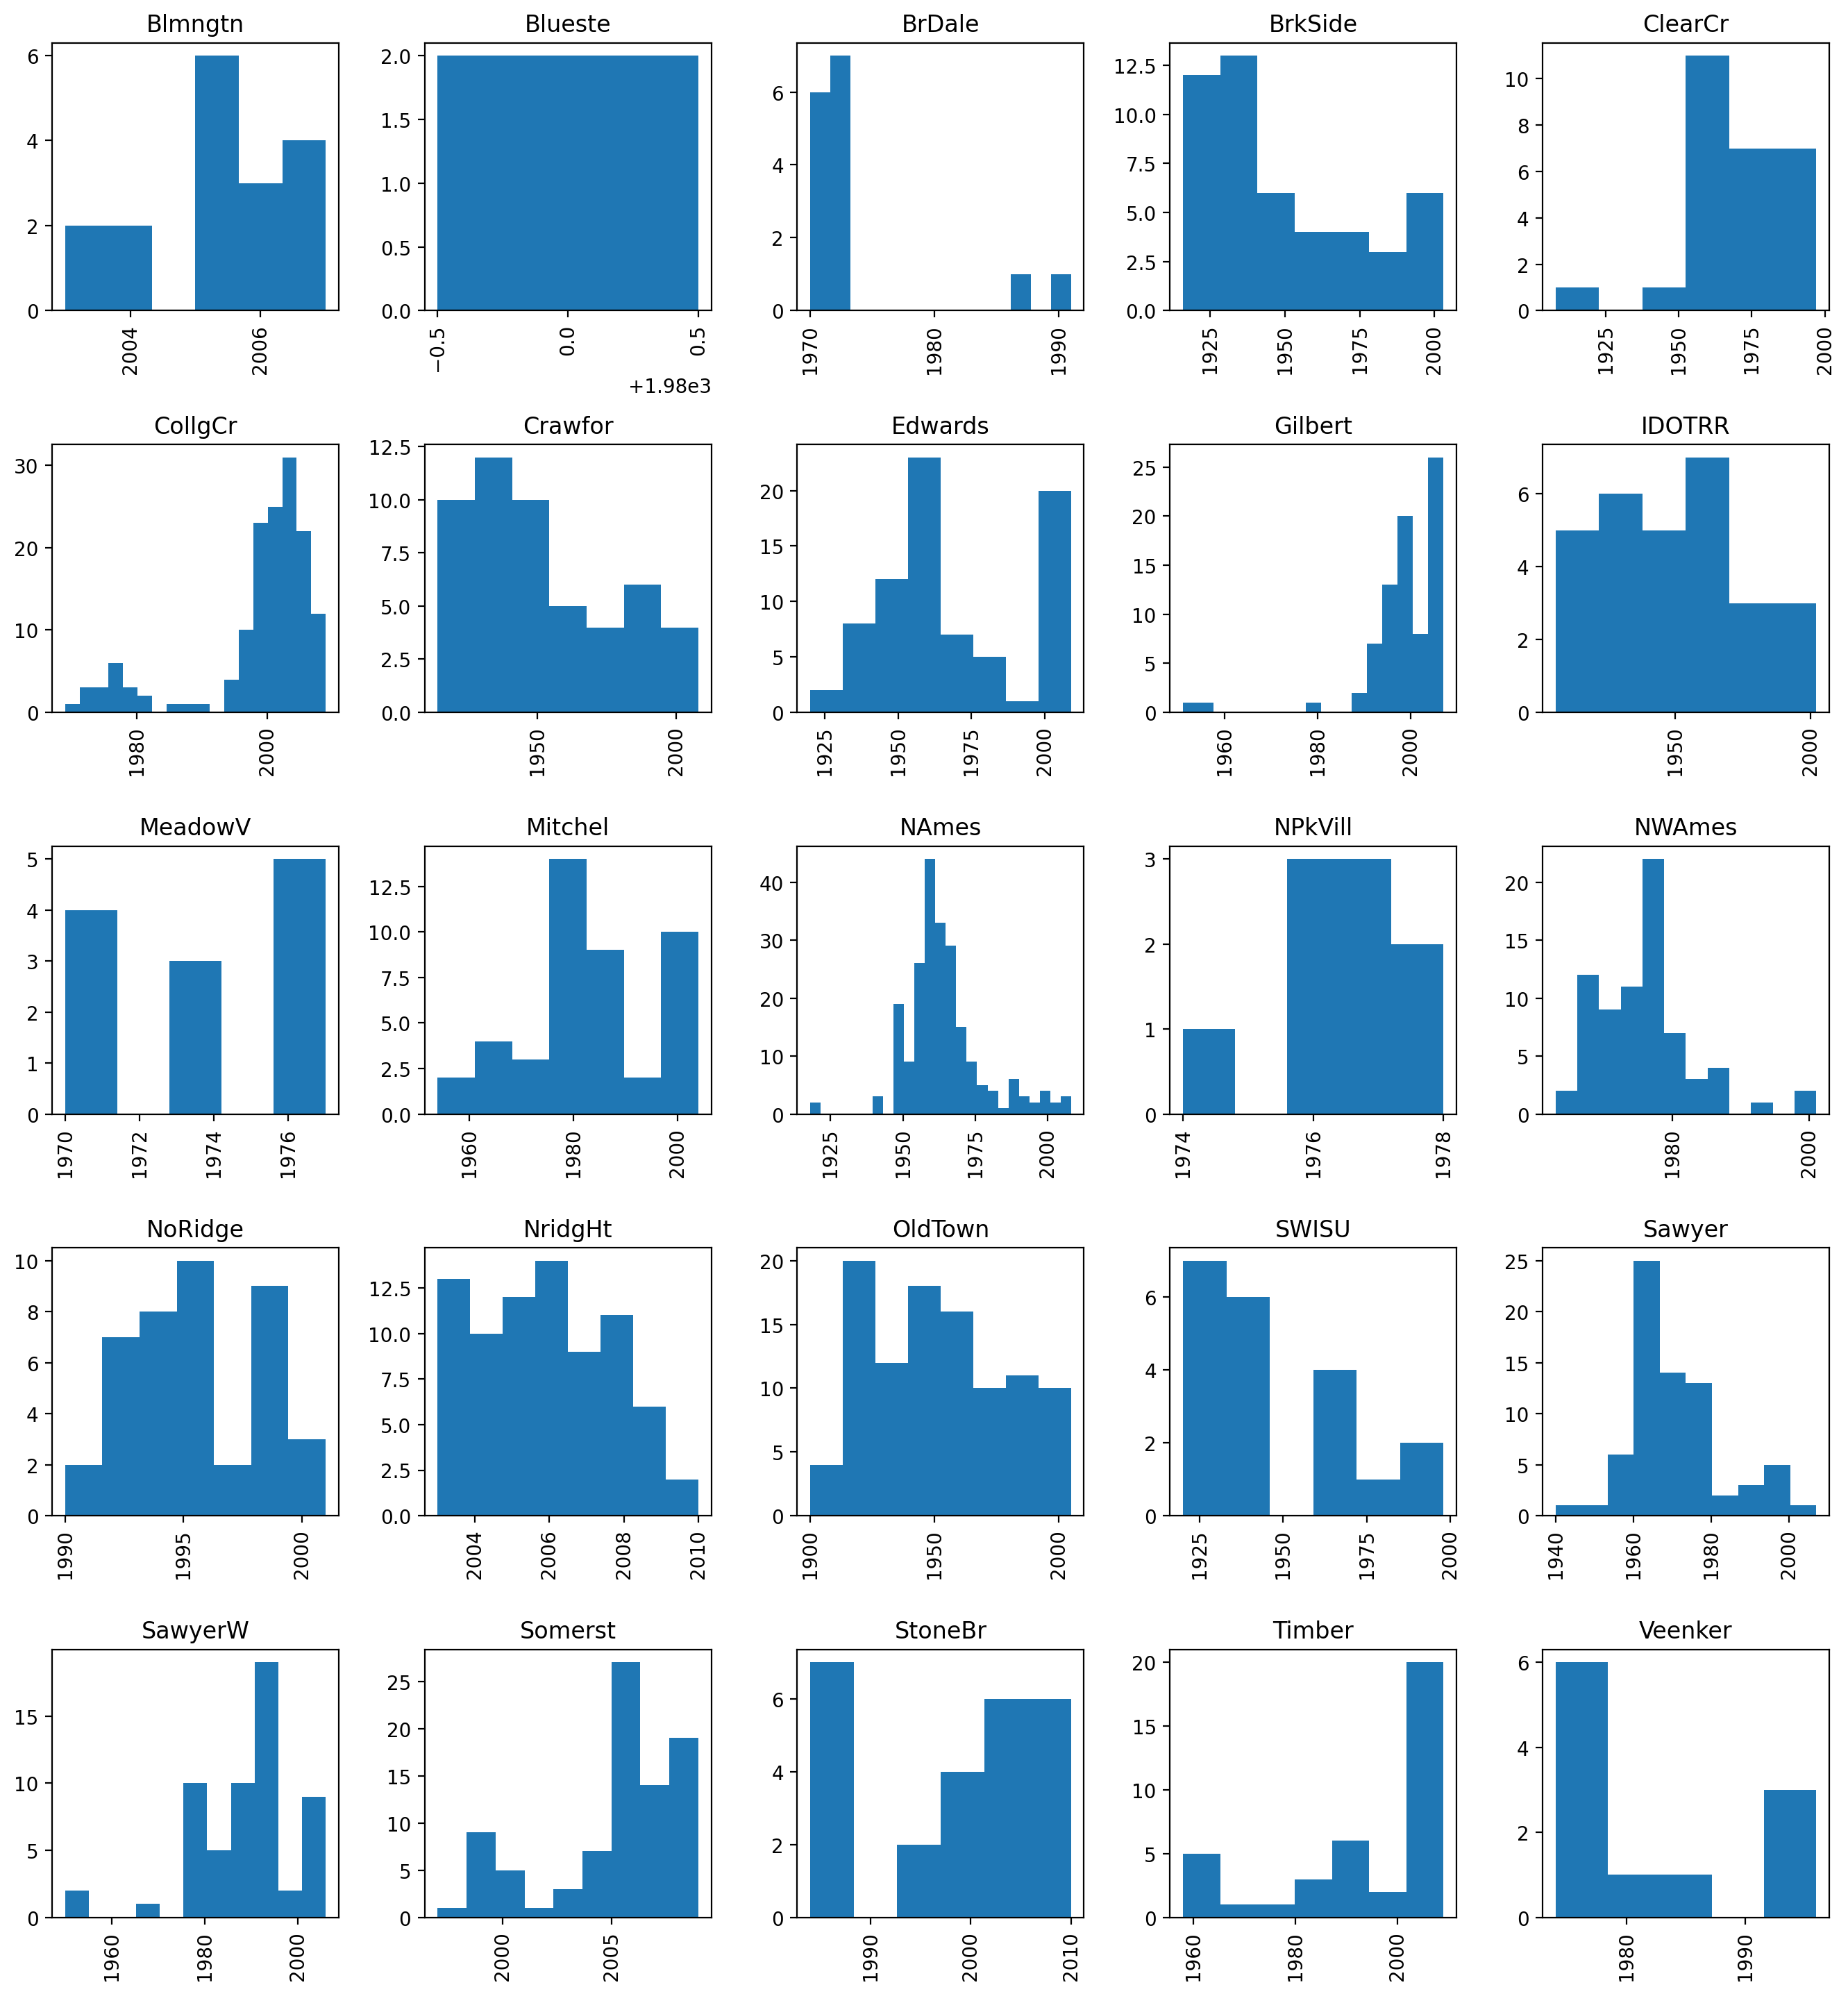

In [41]:
#GarageYrBlt
print(X[X.GarageYrBlt != 'NA'].groupby('Neighborhood')['GarageYrBlt'].describe())
X[X.GarageYrBlt != 'NA']['GarageYrBlt'].hist(by=X[X.GarageYrBlt != 'NA']['Neighborhood'], figsize = (16,18), bins='auto');

In [42]:
# replace missing values with an year of house of building 
for i in range(len(num)):
    if (pd.isna(num.loc[i, 'GarageYrBlt']) == True):
        num.loc[i, 'GarageYrBlt'] = num.loc[i, 'YearBuilt'].astype(int)    
for i in range(len(num_test)):
    if (pd.isna(num_test.loc[i, 'GarageYrBlt'])== True):
        num_test.loc[i, 'GarageYrBlt'] = num_test.loc[i, 'YearBuilt'].astype(int)

In [43]:
num['Garage_age'] = num['YrSold'].astype(int) - num['GarageYrBlt'].astype(int)
num['House_age'] = num['YrSold'].astype(int) - num['YearBuilt'].astype(int)
num['Remod_age'] = num['YrSold'].astype(int) - num['YearRemodAdd'].astype(int)
num = num.drop(['GarageYrBlt', 'YearBuilt', 'YearRemodAdd'  ], axis = 1)

num_test['Garage_age'] = num_test['YrSold'].astype(int) - num_test['GarageYrBlt'].astype(int)
num_test['House_age'] = num_test['YrSold'].astype(int) - num_test['YearBuilt'].astype(int)
num_test['Remod_age'] = num_test['YrSold'].astype(int) - num_test['YearRemodAdd'].astype(int)
num_test = num_test.drop(['GarageYrBlt', 'YearBuilt', 'YearRemodAdd'  ], axis = 1)

Neighborhood  MasVnrArea
Blmngtn       16.0           5
              18.0           2
              72.0           2
              130.0          2
              0.0            1
                            ..
Timber        584.0          1
              630.0          1
              653.0          1
Veenker       0.0           10
              360.0          1
Name: MasVnrArea, Length: 551, dtype: int64


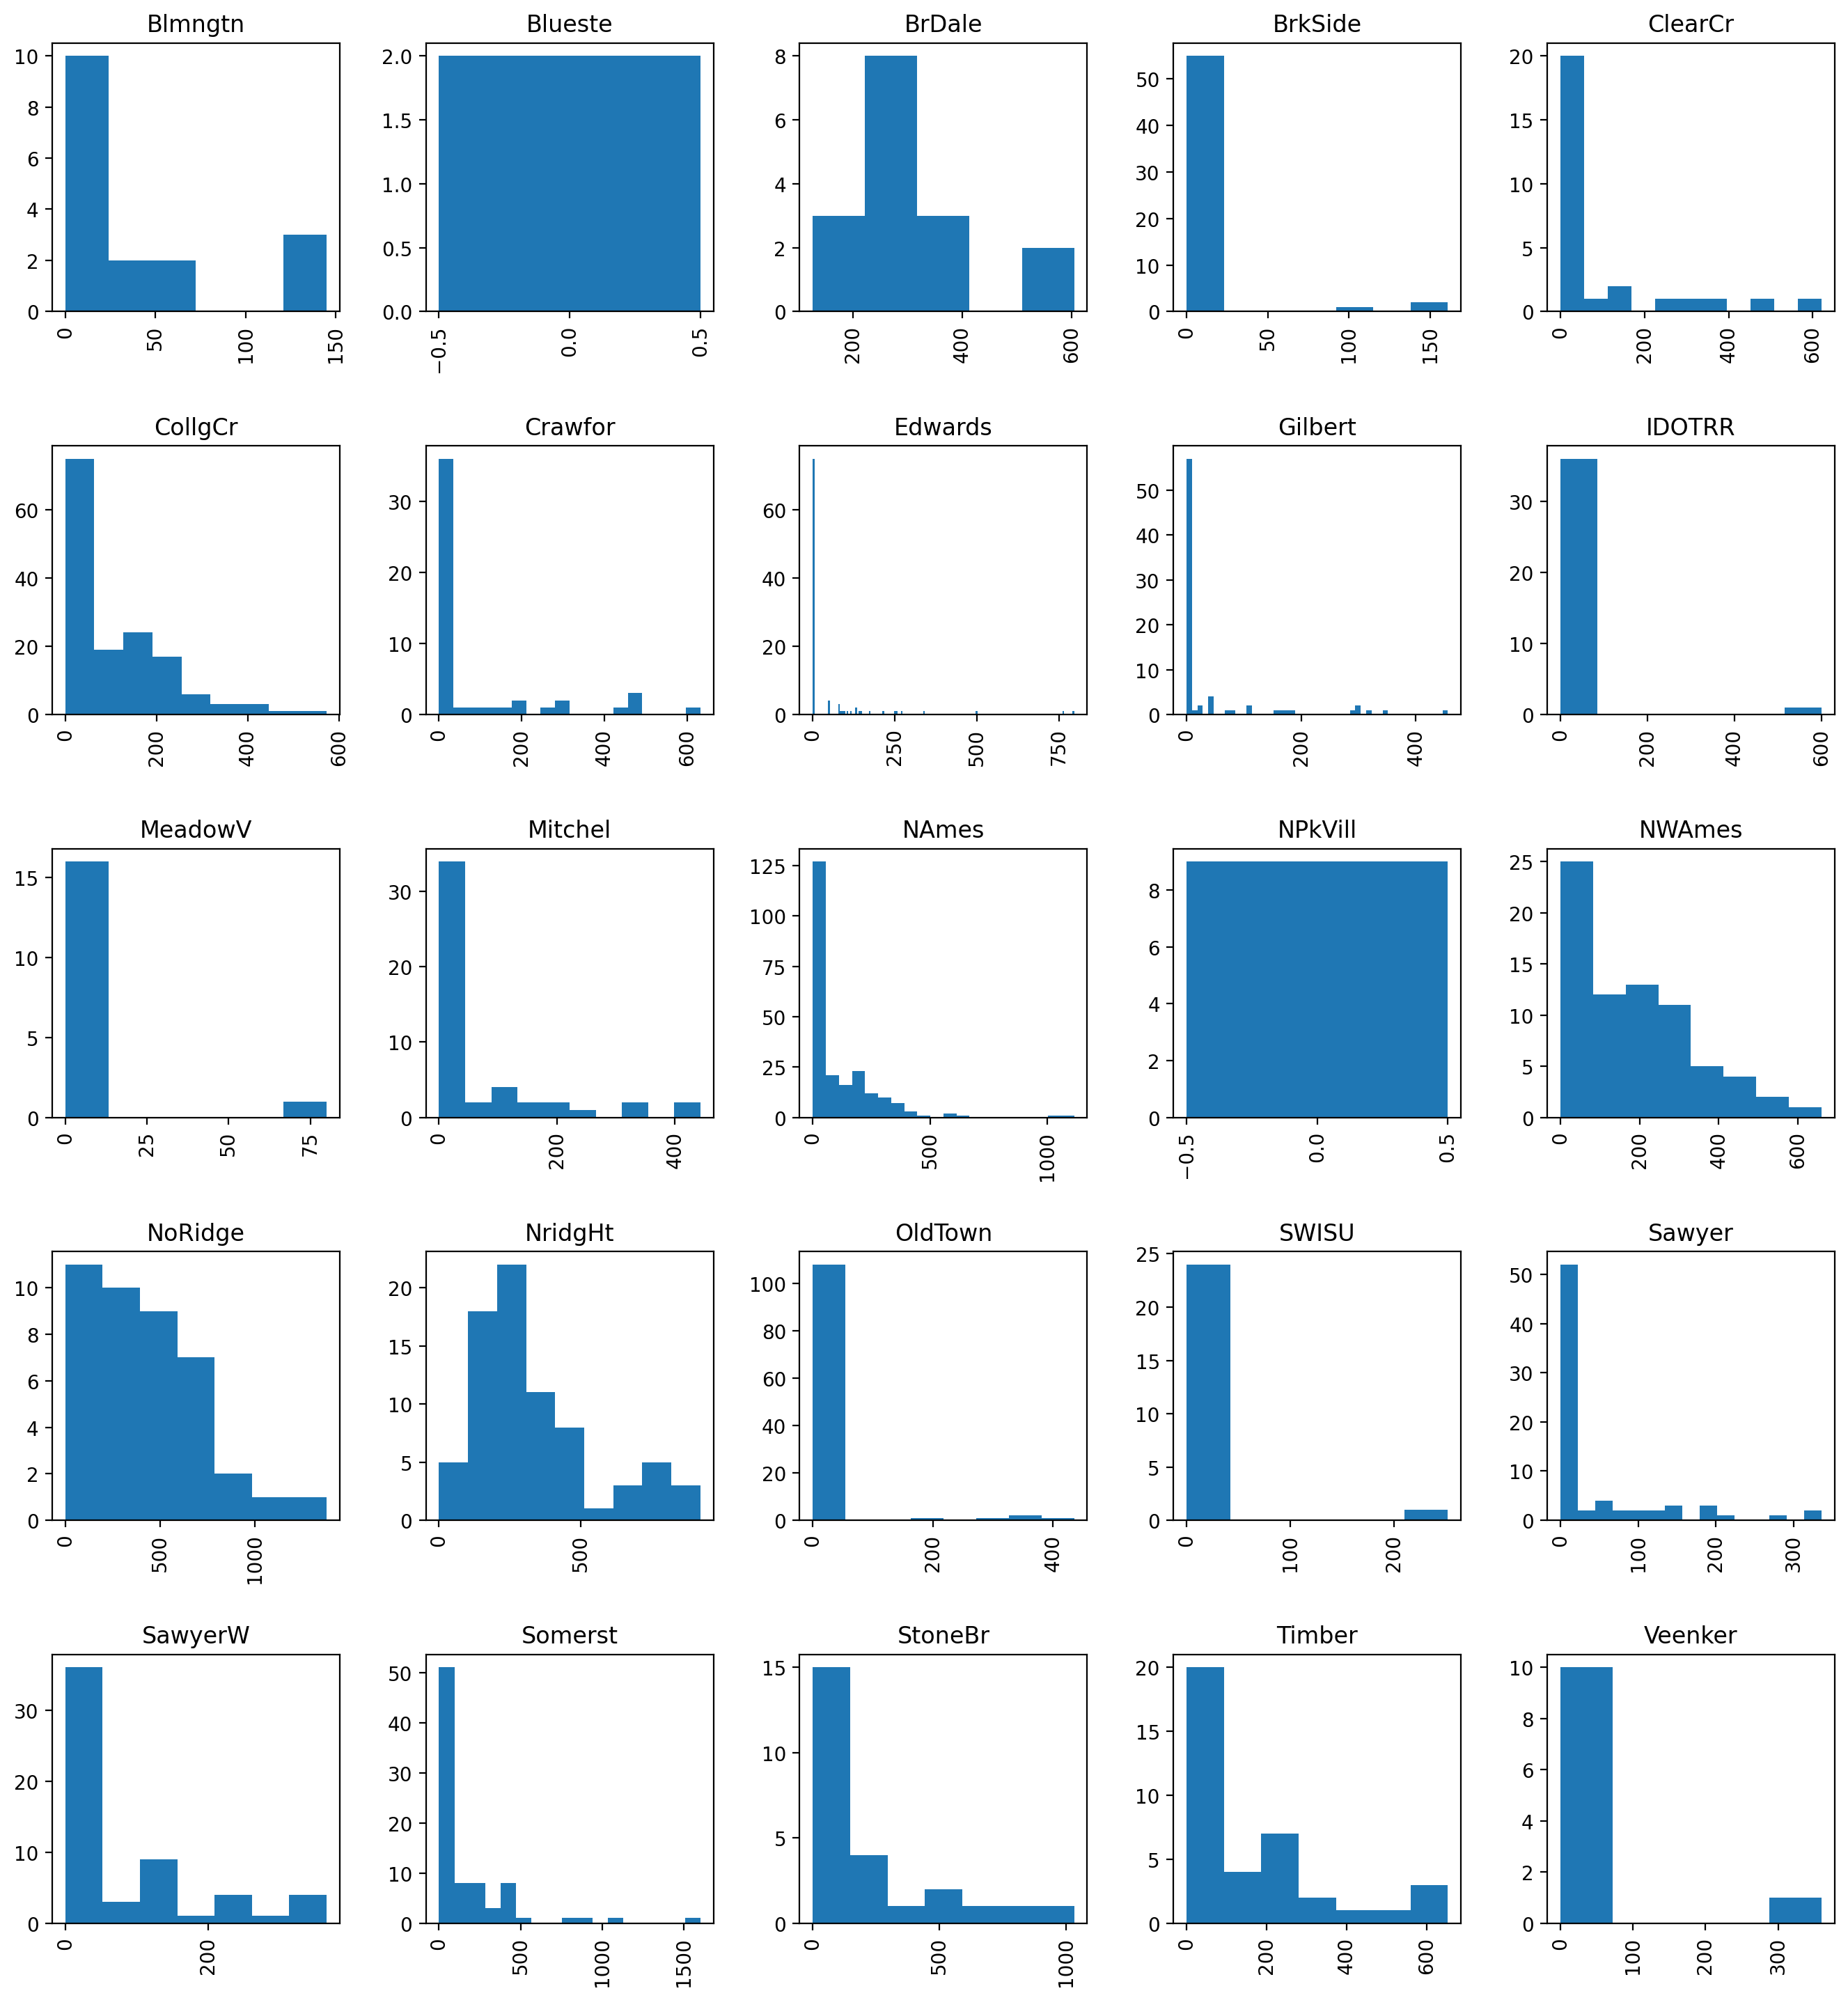

In [44]:
#MasVnrArea
MasVnrArea_NoNA = X[X['MasVnrArea'].notna()][['Neighborhood', 'MasVnrArea']]
print(MasVnrArea_NoNA.groupby('Neighborhood')['MasVnrArea'].value_counts())
#print the histograms using Freedman-Diaconis method for setting the number of bins
MasVnrArea_NoNA['MasVnrArea'].hist(by=MasVnrArea_NoNA['Neighborhood'], figsize = (16,18), bins='auto');
# we can see, that in most cases each neighborhood has its own the most frequent value of MasVnrArea.

Neighborhood  MasVnrArea
Blmngtn       16.0          7
              14.0          4
              18.0          3
              72.0          3
              40.0          2
                           ..
Veenker       272.0         1
              360.0         1
              450.0         1
              600.0         1
              1050.0        1
Name: MasVnrArea, Length: 963, dtype: int64


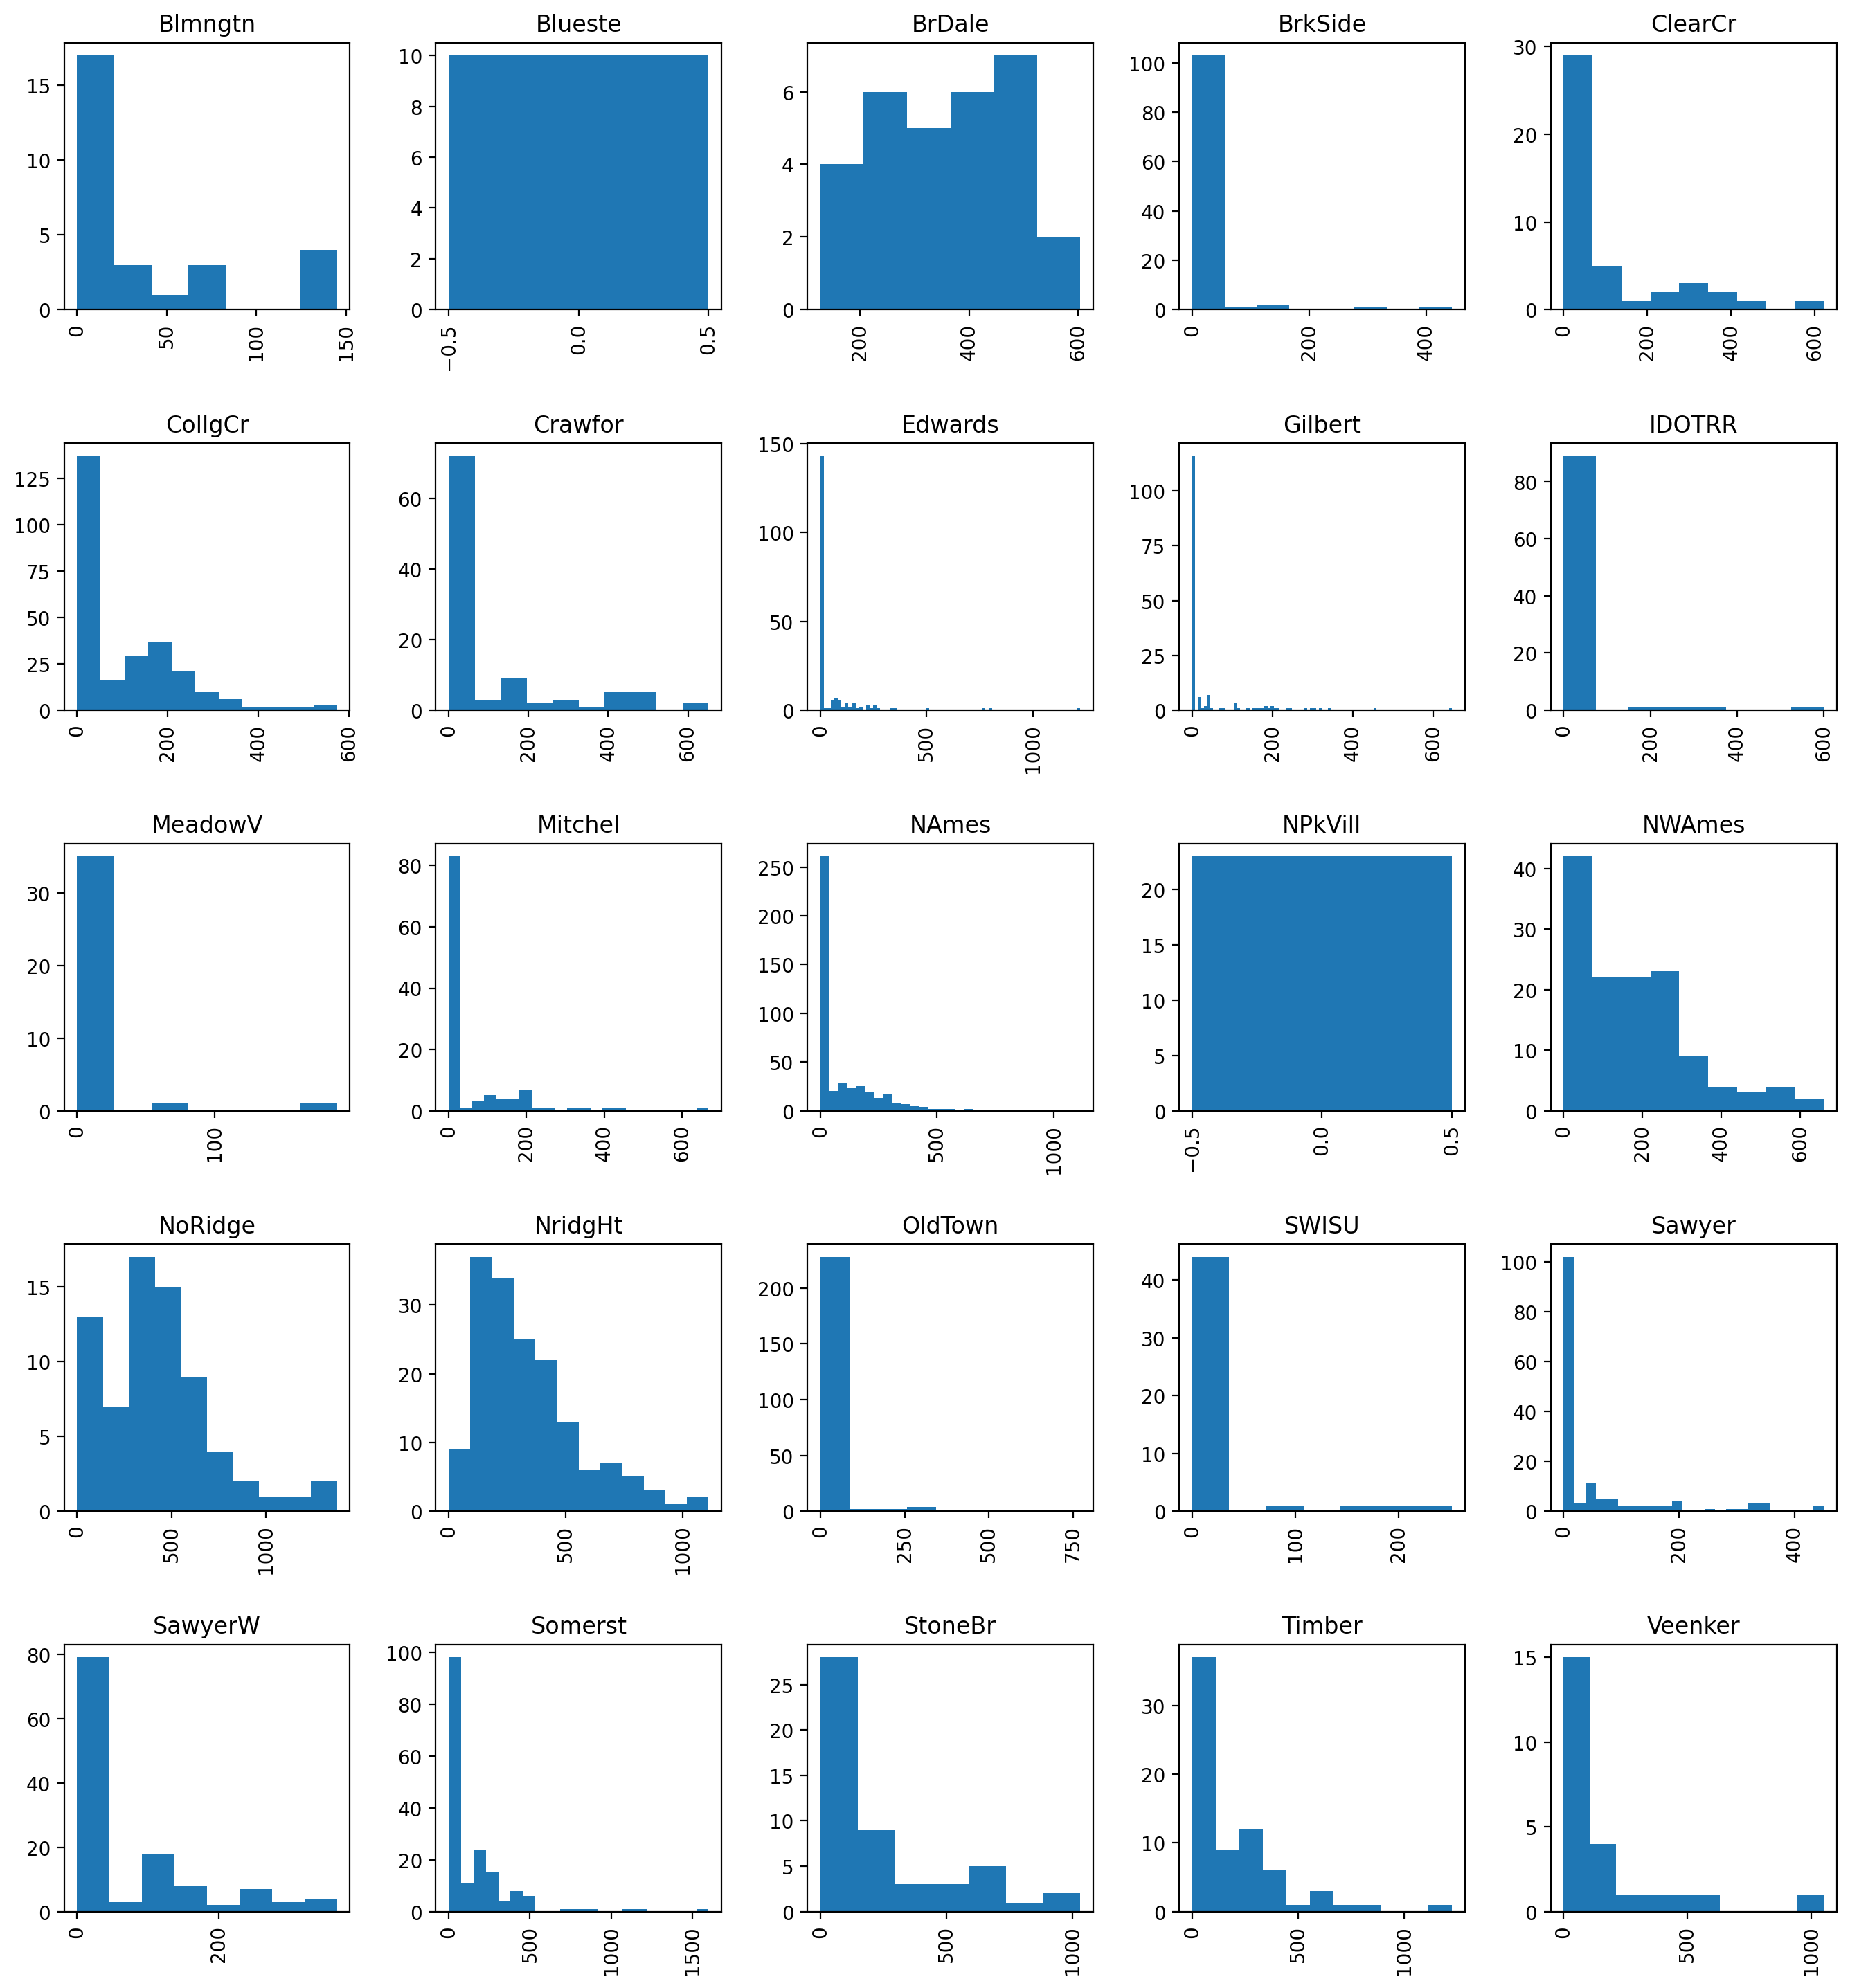

In [45]:
# So, it is reasonable to replace missing values with group mode or group median. As we have train and test datasets, we can find the global mode
glob_mas = pd.concat([X[X.MasVnrArea.notna()][['Neighborhood', 'MasVnrArea' ]],test[test.MasVnrArea.notna()][['Neighborhood', 'MasVnrArea' ]]])
print(glob_mas.groupby('Neighborhood')['MasVnrArea'].value_counts())
glob_mas['MasVnrArea'].hist(by=glob_mas['Neighborhood'], figsize = (16,18), bins='auto');

In [46]:
#Let's compare Medians and Modes:
glob_mas['Mode'] = glob_mas.groupby('Neighborhood')['MasVnrArea'].transform(lambda x: x.value_counts().index[0])
glob_mas['Median'] = glob_mas.groupby('Neighborhood')['MasVnrArea'].transform('median')
Mode_mas = glob_mas.drop_duplicates(subset=['Neighborhood'])[['Neighborhood', 'Mode']]
Median_mas = glob_mas.drop_duplicates(subset=['Neighborhood'])[['Neighborhood', 'Median']]
Mas_central = pd.concat([Mode_mas, Median_mas], axis=1).T.drop_duplicates().T
print(Mas_central)

    Neighborhood   Mode Median
0        CollgCr    0.0    0.0
1        Veenker    0.0    0.0
3        Crawfor    0.0    0.0
4        NoRidge    0.0  391.0
5        Mitchel    0.0    0.0
6        Somerst    0.0   15.0
7         NWAmes    0.0  160.0
8        OldTown    0.0    0.0
9        BrkSide    0.0    0.0
10        Sawyer    0.0    0.0
11       NridgHt    0.0  280.0
14         NAmes    0.0    0.0
18       SawyerW    0.0    0.0
21        IDOTRR    0.0    0.0
23       MeadowV    0.0    0.0
39       Edwards    0.0    0.0
41        Timber    0.0   94.0
50       Gilbert    0.0    0.0
58       StoneBr    0.0   16.0
69       ClearCr    0.0    0.0
126      NPkVill    0.0    0.0
219      Blmngtn   16.0   18.0
225       BrDale  504.0  367.5
267        SWISU    0.0    0.0
599      Blueste    0.0    0.0


4 highest bins for NoRidge : [17. 15. 13.  9.]
  their ranges:  [(275.6, 413.40000000000003), (413.40000000000003, 551.2), (0.0, 137.8), (551.2, 689.0)]


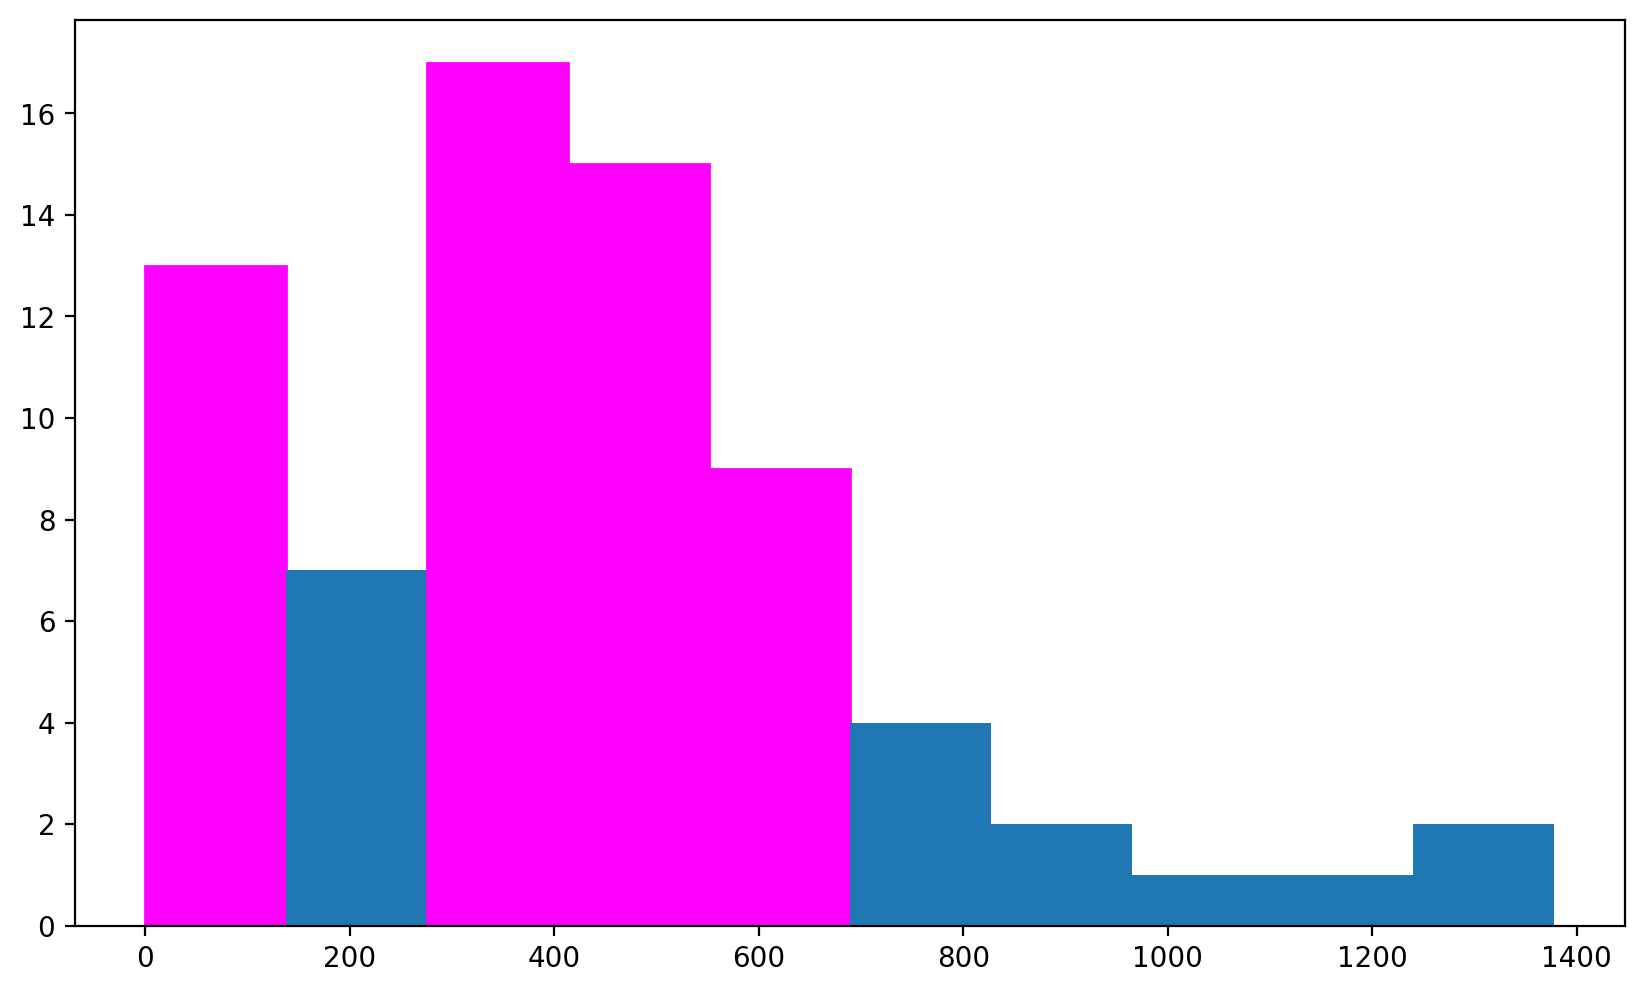

4 highest bins for NWAmes : [42. 23. 22. 22.]
  their ranges:  [(0.0, 73.33333333333333), (220.0, 293.3333333333333), (146.66666666666666, 220.0), (73.33333333333333, 146.66666666666666)]


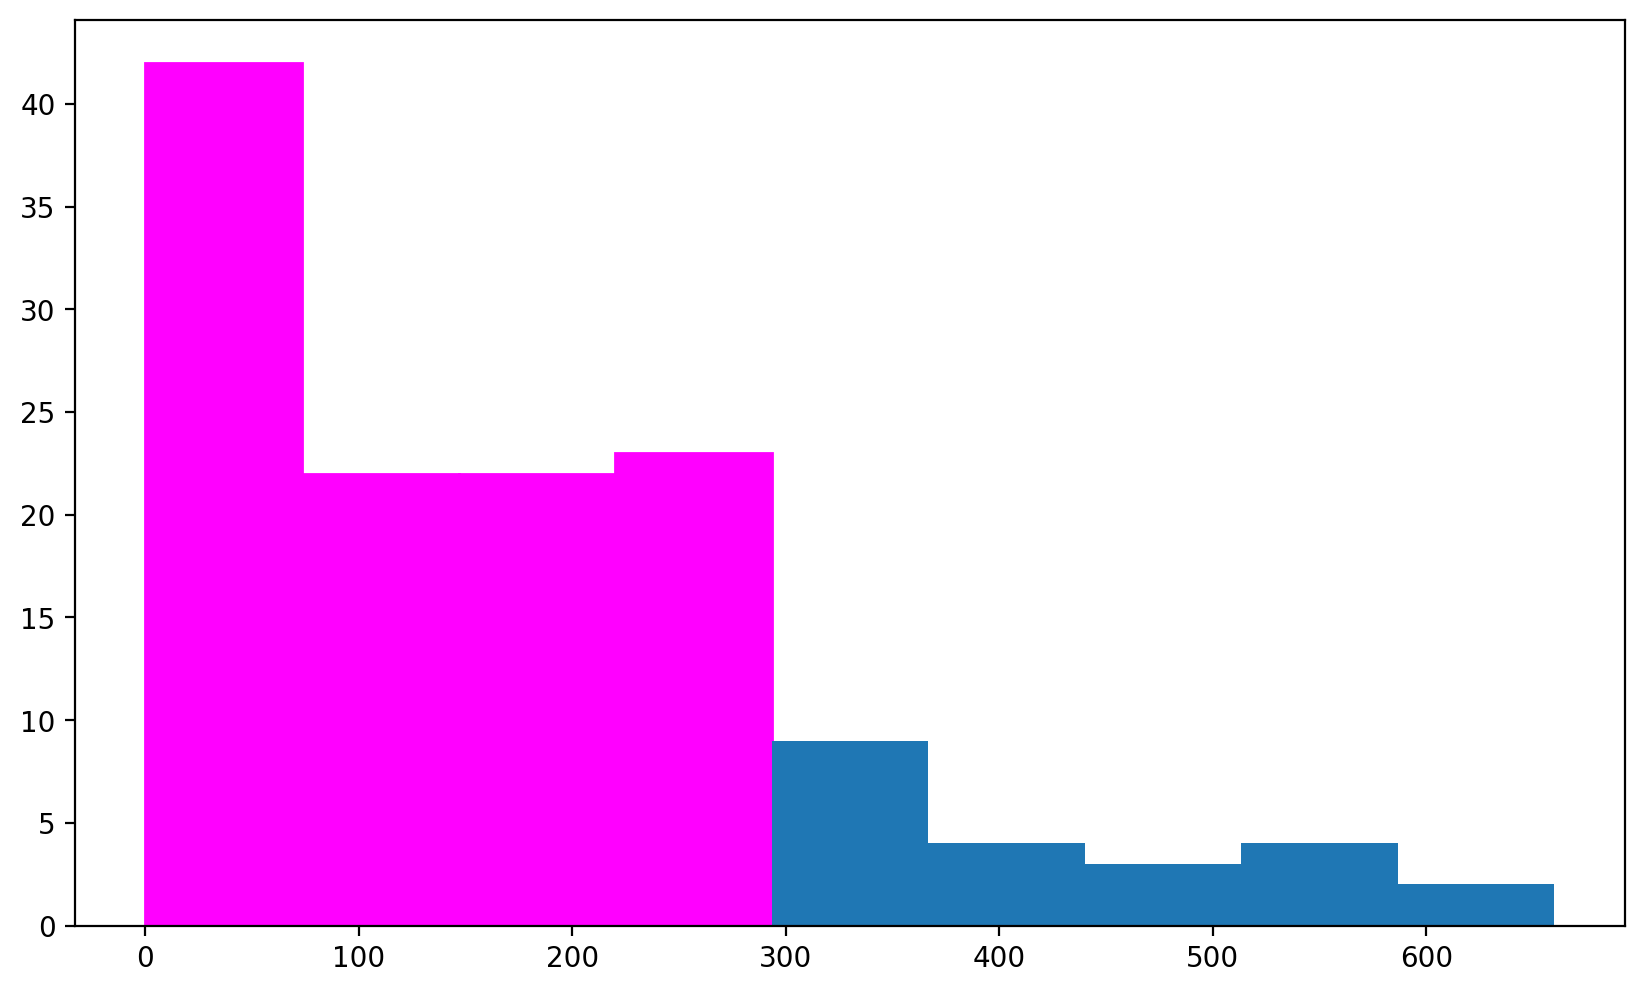

4 highest bins for NridgHt : [37. 34. 25. 22.]
  their ranges:  [(92.5, 185.0), (185.0, 277.5), (277.5, 370.0), (370.0, 462.5)]


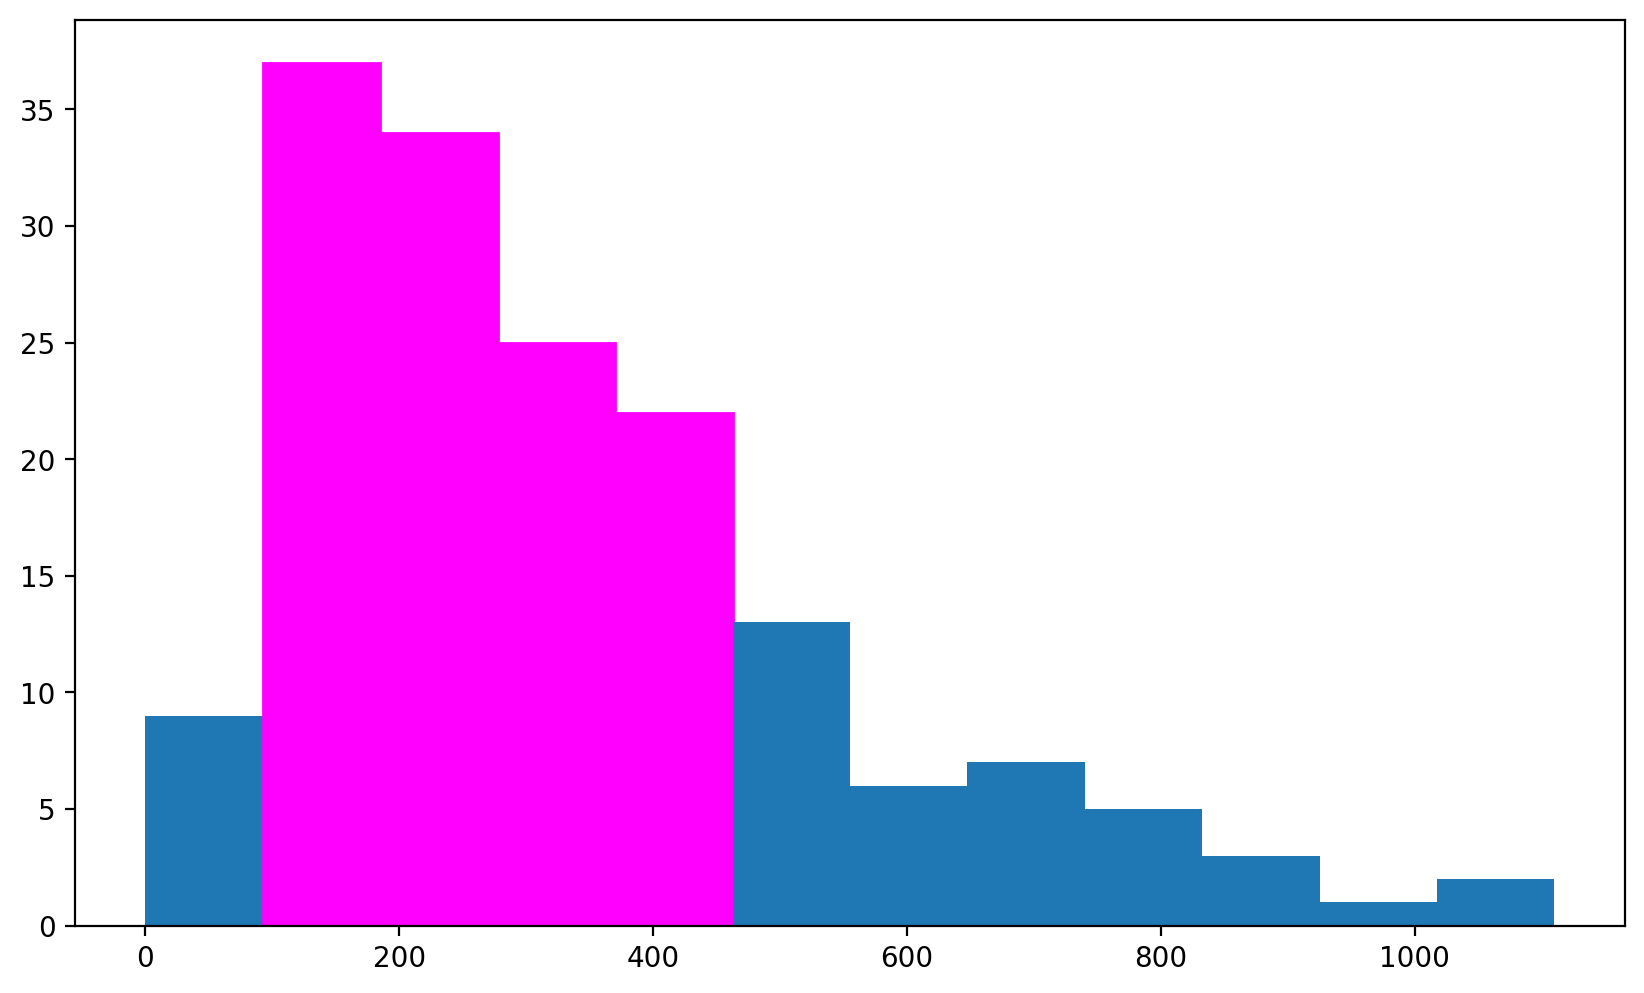

4 highest bins for Timber : [37. 12.  9.  6.]
  their ranges:  [(0.0, 111.27272727272727), (222.54545454545453, 333.8181818181818), (111.27272727272727, 222.54545454545453), (333.8181818181818, 445.09090909090907)]


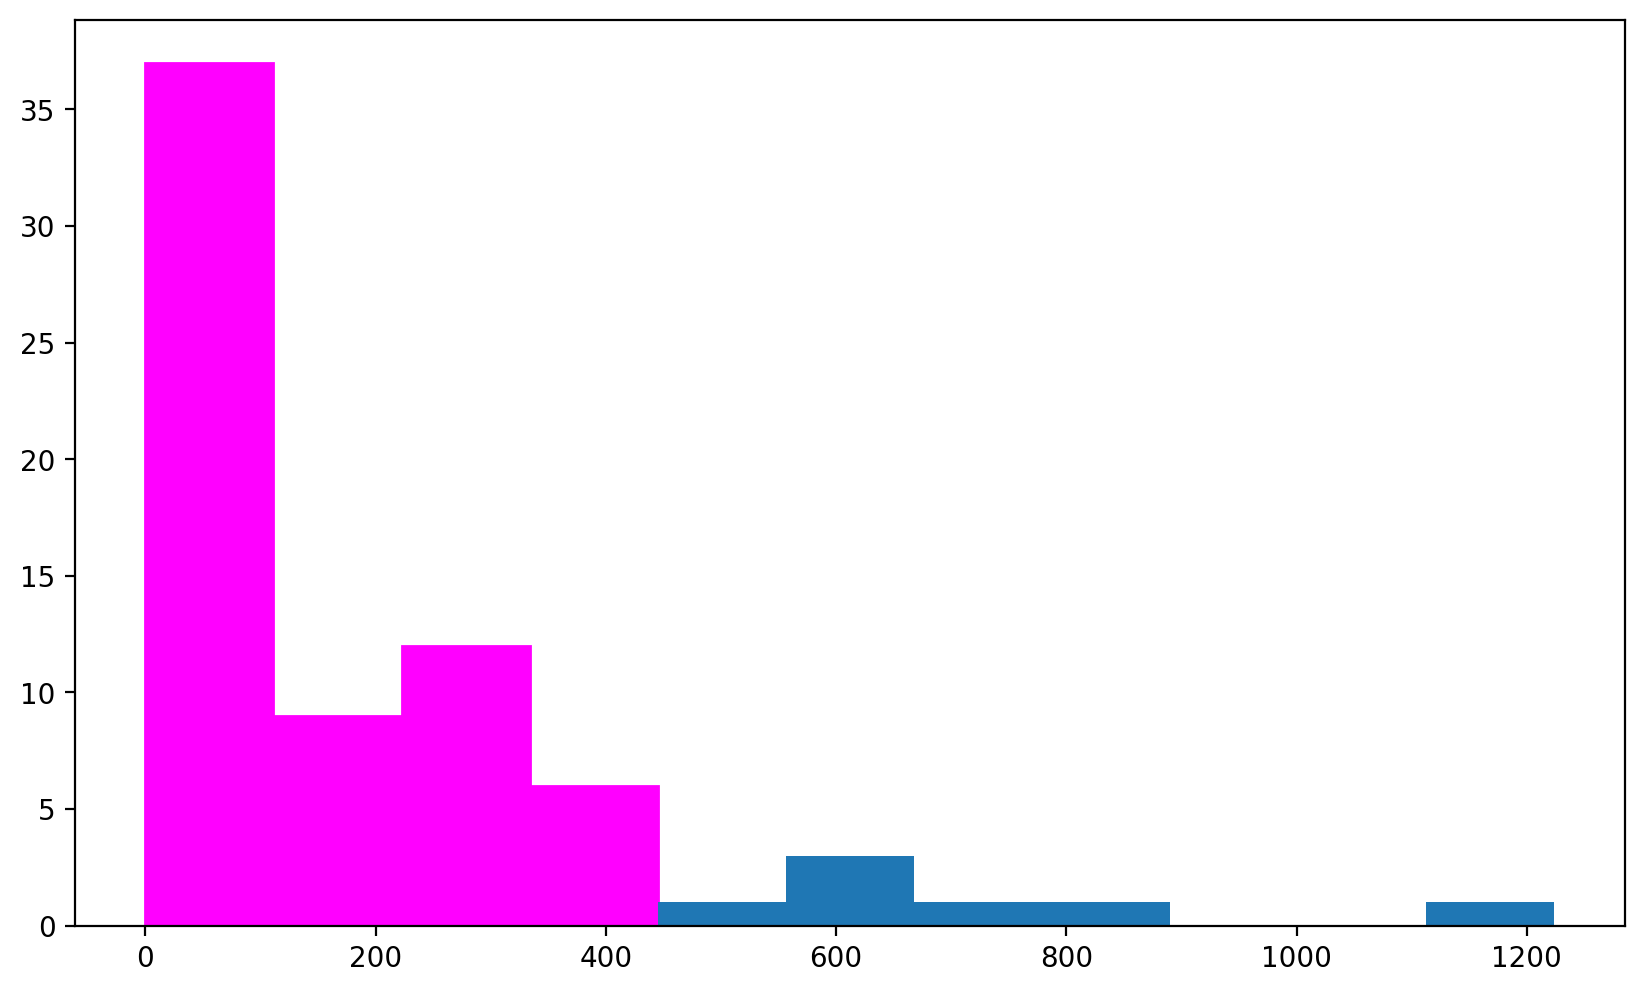

4 highest bins for Blmngtn : [17.  4.  3.  3.]
  their ranges:  [(0.0, 20.714285714285715), (124.28571428571429, 145.0), (62.142857142857146, 82.85714285714286), (20.714285714285715, 41.42857142857143)]


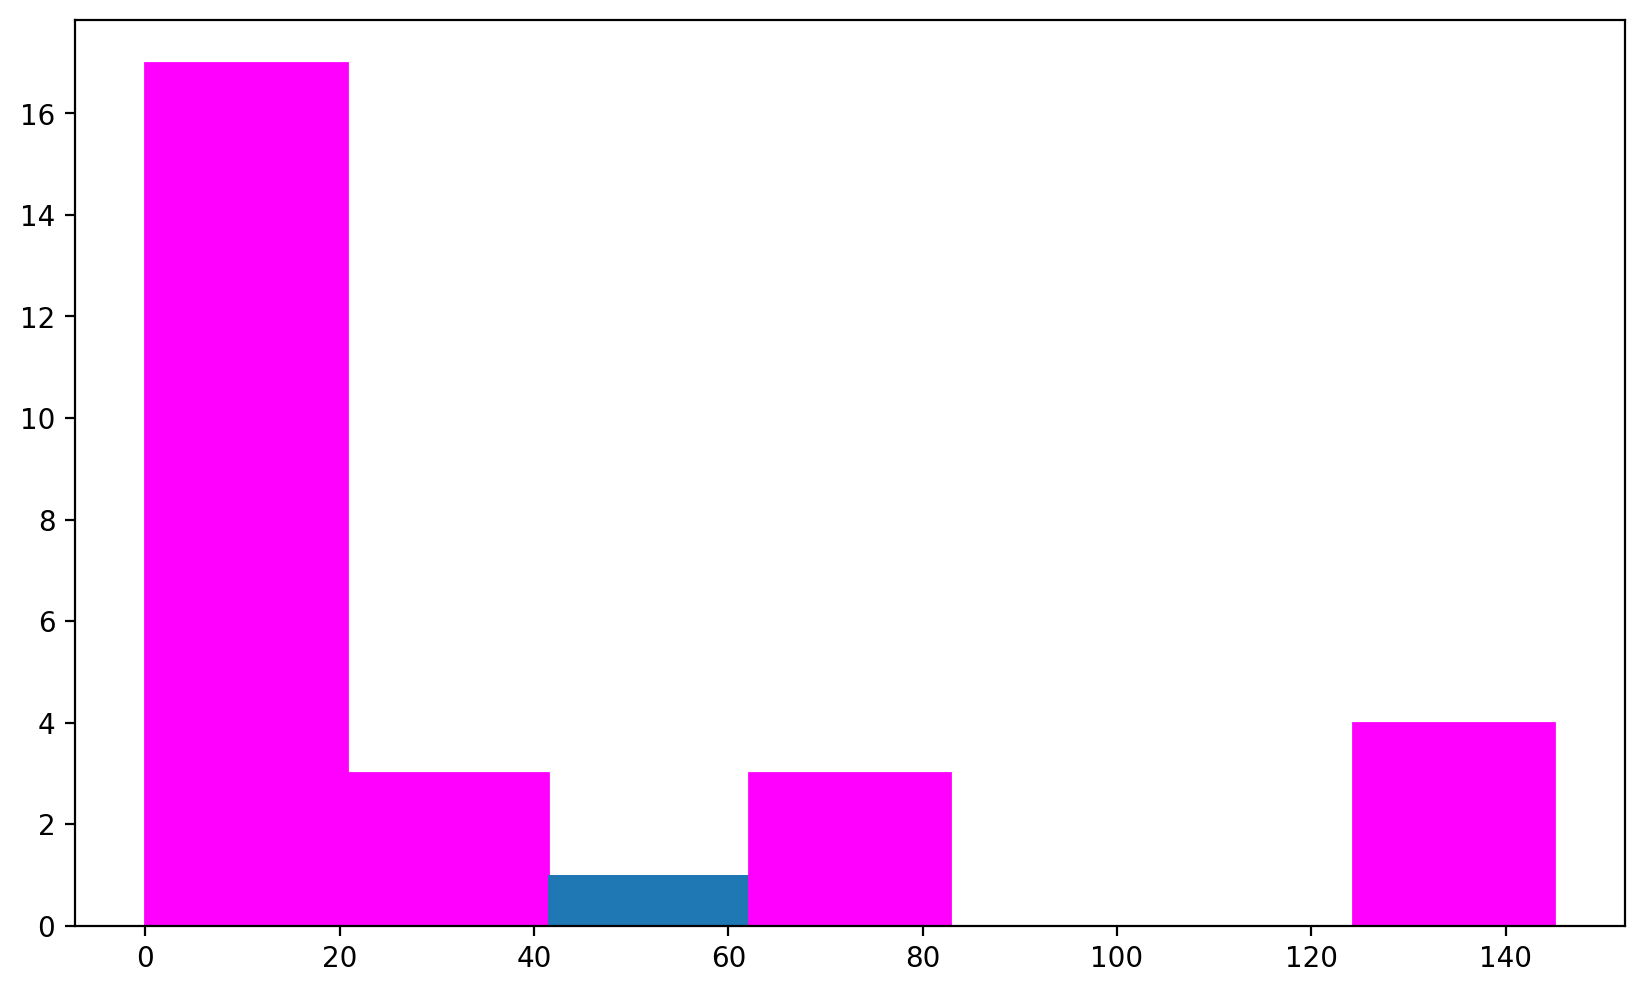

4 highest bins for BrDale : [7. 6. 6. 5.]
  their ranges:  [(445.0, 524.5), (365.5, 445.0), (206.5, 286.0), (286.0, 365.5)]


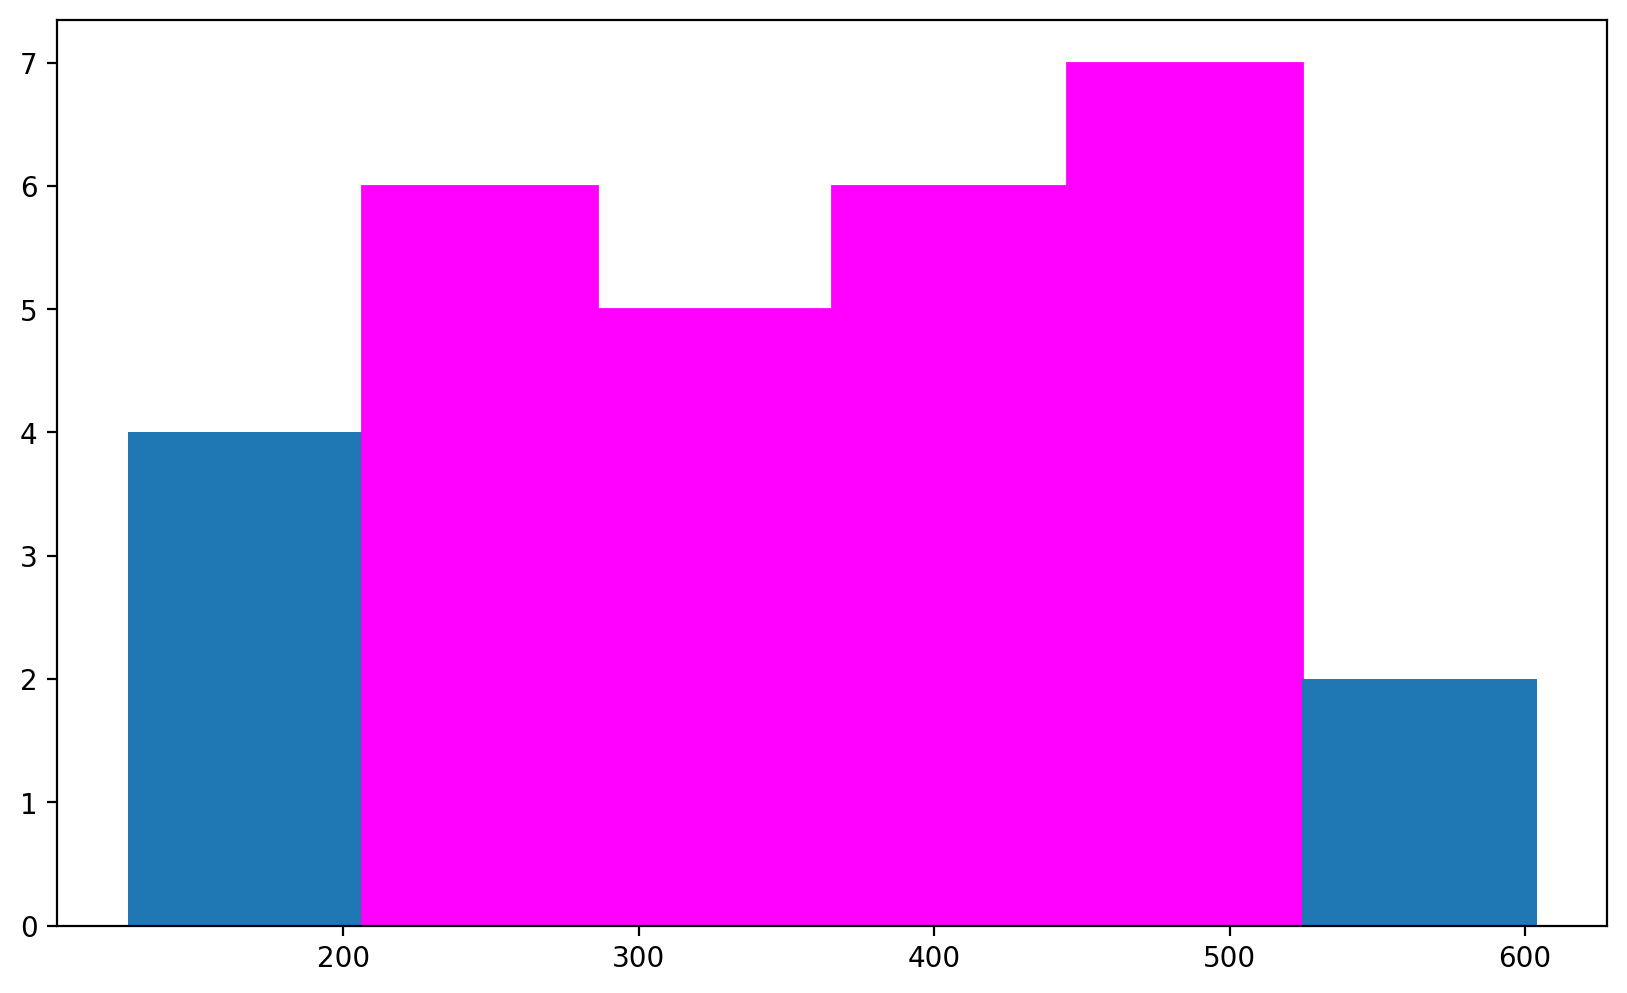

In [47]:
#let's check the ambiguous cases:
# NoRidge
def peaks(neighbor): 
    plt.figure(1,figsize=(10, 6))
    values, bins, patches = plt.hist(glob_mas[glob_mas['Neighborhood'] == neighbor]['MasVnrArea'], bins='auto')
    order = np.argsort(values)[::-1]
    print('4 highest bins for', neighbor, ':', values[order][:4])
    print('  their ranges: ',  [ (bins[i], bins[i+1])   for i in order[:4]])
    for i in order[:4]:
        patches[i].set_color('fuchsia')
    return plt.show()
peaks('NoRidge')
peaks('NWAmes')
peaks('NridgHt')
peaks('Timber')
peaks('Blmngtn')
peaks('BrDale')
#Source: https://stackoverflow.com/questions/61443405/how-to-get-k-max-values-from-a-histogram

In [48]:
# It seems that imputation with Median is a bit better than using Mode. 
# Let's replace missing values with global Median mode.
for i in range(len(X)):
    if (pd.isna(X.iloc[i].MasVnrArea) == True):
        neigh = X.iloc[i].Neighborhood
        X.loc[i, 'MasVnrArea'] = Mas_central[Mas_central.Neighborhood == neigh].Median.to_string(index=False)
# Do the same for test:
for i in range(len(test)):
    if pd.isna(test.iloc[i].MasVnrArea) == True:
        neigh = test.iloc[i].Neighborhood
        test.loc[i, 'MasVnrArea'] = Mas_central[Mas_central.Neighborhood == neigh].Median.to_string(index=False)

In [49]:
num.MasVnrArea = X.MasVnrArea
num_test.MasVnrArea = test.MasVnrArea
num.MasVnrArea = pd.to_numeric(num.MasVnrArea)
num_test.MasVnrArea = pd.to_numeric(num_test.MasVnrArea)

In [50]:
# Bsmt
print(test[test.BsmtFullBath.isna()][[col for col in test.columns if 'Bsmt' in col]])
print(test[test.BsmtFinType1.isna()][[col for col in test.columns if 'Bsmt' in col]])

     BsmtQual  BsmtCond  BsmtExposure  BsmtFinType1  BsmtFinSF1  BsmtFinType2  \
660         0         0             0             0         NaN             0   
728         0         0             0             0         0.0             0   

     BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  BsmtFullBath  BsmtHalfBath  
660         NaN        NaN          NaN           NaN           NaN  
728         0.0        0.0          0.0           NaN           NaN  
Empty DataFrame
Columns: [BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinSF1, BsmtFinType2, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath, BsmtHalfBath]
Index: []


In [51]:
# replace BsmtFullBath, BsmtFinSF2, BsmtHalfBath, BsmtUnfSF, TotalBsmtSF, BsmtFinSF1's 'NA' with 0 
ind_bsmt_NA = [*num_test[num_test.BsmtFullBath.isna()].index]
for col in num_test.columns:
    if col in ['BsmtFullBath', 'BsmtFinSF2', 'BsmtHalfBath', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFinSF1']:
        for j in range(len(ind_bsmt_NA)):
            num_test.loc[ind_bsmt_NA[j], col] = 0

In [52]:
# GaregeArea
print(test[pd.isna(test.GarageArea)][test.columns[pd.Series(test.columns).str.startswith('Garage')]])
print(test[pd.isna(test.GarageCars)][test.columns[pd.Series(test.columns).str.startswith('Garage')]])
# we might see that garage is not finished and garage area and garage cars NA are in the same cell with index 1116
print(test.loc[test['GarageType'].isin(['NA'])][test.columns[pd.Series(test.columns).str.startswith('Garage')]])

     GarageType  GarageYrBlt  GarageFinish  GarageCars  GarageArea  \
1116     Detchd          NaN             0         NaN         NaN   

      GarageQual  GarageCond  
1116           0           0  
     GarageType  GarageYrBlt  GarageFinish  GarageCars  GarageArea  \
1116     Detchd          NaN             0         NaN         NaN   

      GarageQual  GarageCond  
1116           0           0  
     GarageType  GarageYrBlt  GarageFinish  GarageCars  GarageArea  \
53           NA          NaN             0         0.0         0.0   
71           NA          NaN             0         0.0         0.0   
79           NA          NaN             0         0.0         0.0   
92           NA          NaN             0         0.0         0.0   
96           NA          NaN             0         0.0         0.0   
...         ...          ...           ...         ...         ...   
1433         NA          NaN             0         0.0         0.0   
1449         NA          NaN      

In [53]:
# it will be better to replace GarageArea and GarageCars 'NA' with 0
num_test.loc[pd.isna(num_test.GarageArea).index,'GarageArea'] = 0
num_test.loc[pd.isna(num_test.GarageCars).index,'GarageCars'] = 0
print(num_test.iloc[1116][num_test.columns[pd.Series(num_test.columns).str.startswith('Garage')]])

GarageCars     0.0
GarageArea     0.0
Garage_age    84.0
Name: 1116, dtype: float64


In [54]:
################################################
#LotFrontage
################################################

Neighborhood  LotFrontage
Blmngtn       43.0           12
              53.0            7
              51.0            1
Blueste       24.0            7
              35.0            3
                             ..
Veenker       94.0            1
              95.0            1
              100.0           1
              103.0           1
              110.0           1
Name: LotFrontage, Length: 758, dtype: int64


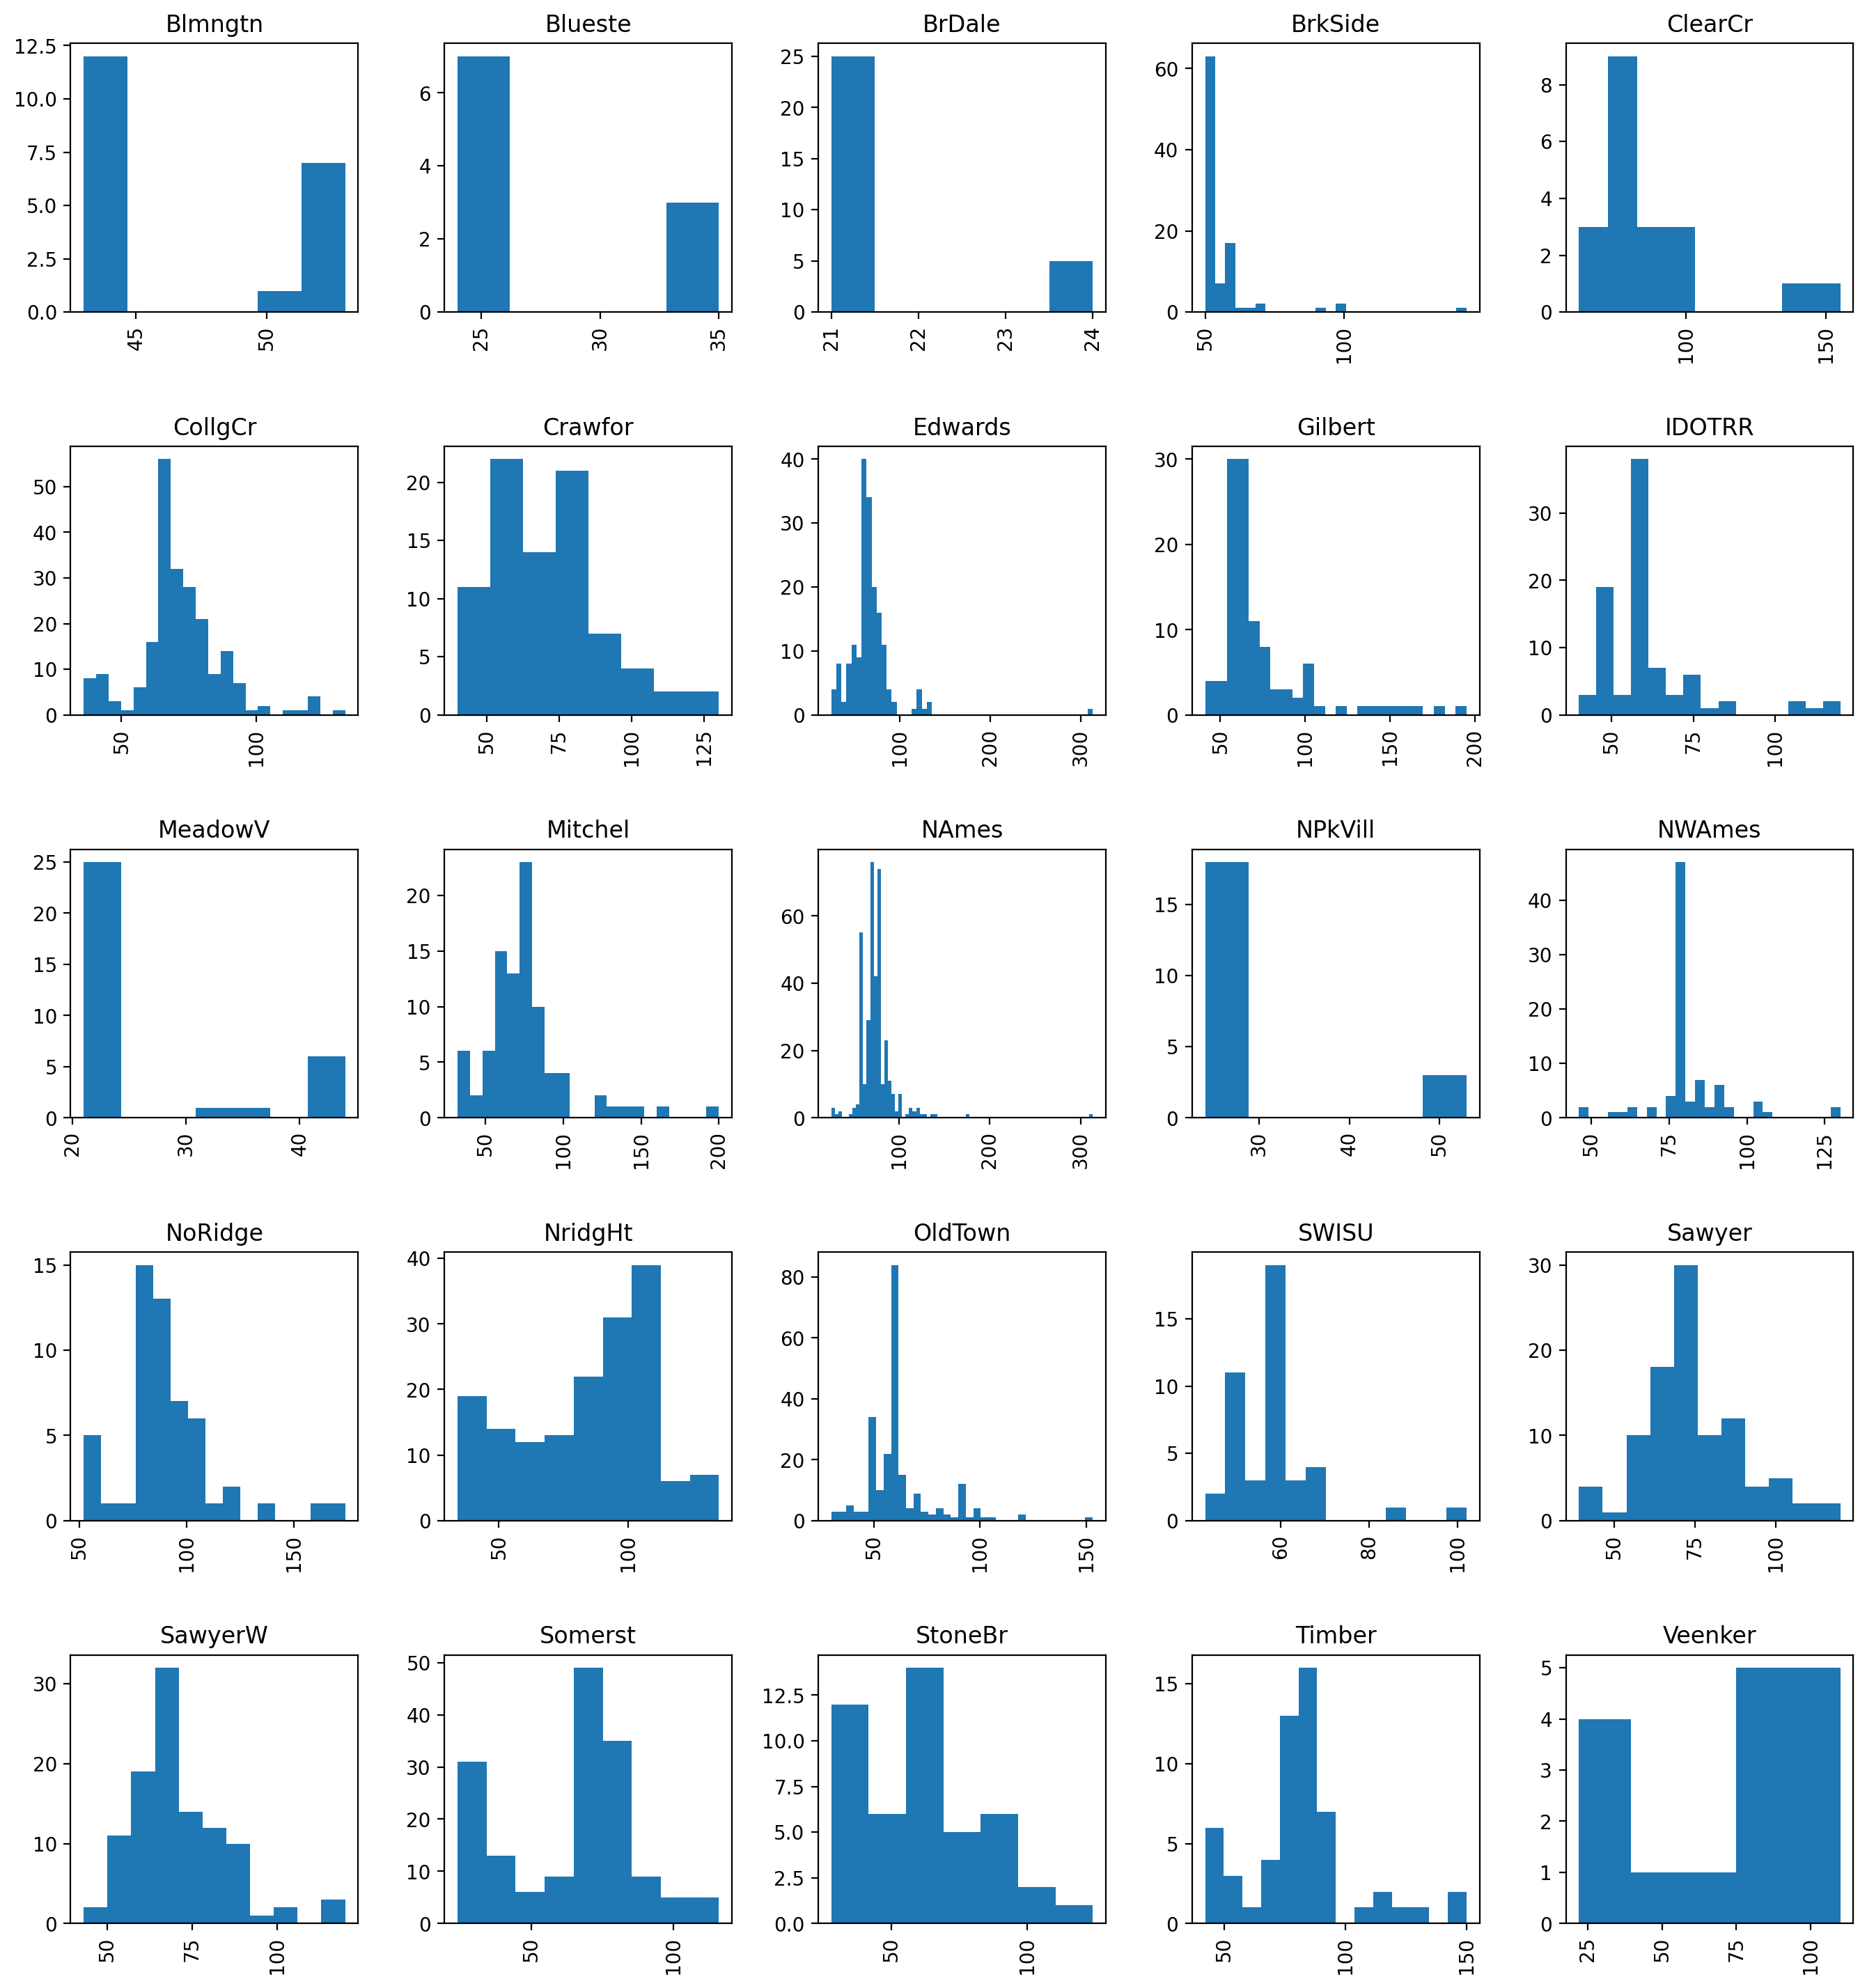

In [55]:
# check, if LotFrontage depedends on Neighborhod
glob_lf = pd.concat([X[X.LotFrontage.notna()][['Neighborhood', 'LotFrontage', 'LotArea', 'LotShape', 'LotConfig']],test[test.LotFrontage.notna()][['Neighborhood', 'LotFrontage', 'LotArea', 'LotShape', 'LotConfig']]])
print(glob_lf.groupby('Neighborhood')['LotFrontage'].value_counts())
glob_lf['LotFrontage'].hist(by=glob_lf['Neighborhood'], figsize = (16,18), bins = 'auto');

In [56]:
num.LotFrontage.isna().sum()
num_test.LotFrontage.isna().sum()
# In sum, we have 486 missing values in LotFrontage (almost 17%), so it is better to try to build model for prediction.
# Let's try RandomForest model and XGBoost, as they are robust to outliers

227

              count       mean        std   min    25%   50%     75%    max
Neighborhood                                                               
Blmngtn        20.0  46.900000   4.919350  43.0  43.00  43.0   53.00   53.0
Blueste        10.0  27.300000   5.313505  24.0  24.00  24.0   32.25   35.0
BrDale         30.0  21.500000   1.137147  21.0  21.00  21.0   21.00   24.0
BrkSide        95.0  55.789474  12.722818  50.0  50.00  51.0   58.50  144.0
ClearCr        20.0  88.150000  22.628057  62.0  78.00  80.5   93.25  155.0
CollgCr       220.0  71.336364  15.940401  36.0  64.00  70.0   78.00  133.0
Crawfor        83.0  69.951807  19.141262  40.0  54.00  70.0   80.00  130.0
Edwards       178.0  66.910112  26.372019  24.0  58.25  65.0   74.00  313.0
Gilbert       111.0  74.207207  28.386654  41.0  59.00  64.0   75.00  195.0
IDOTRR         87.0  62.241379  15.454333  40.0  51.00  60.0   63.50  120.0
MeadowV        33.0  25.606061   8.521808  21.0  21.00  21.0   21.00   44.0
Mitchel     

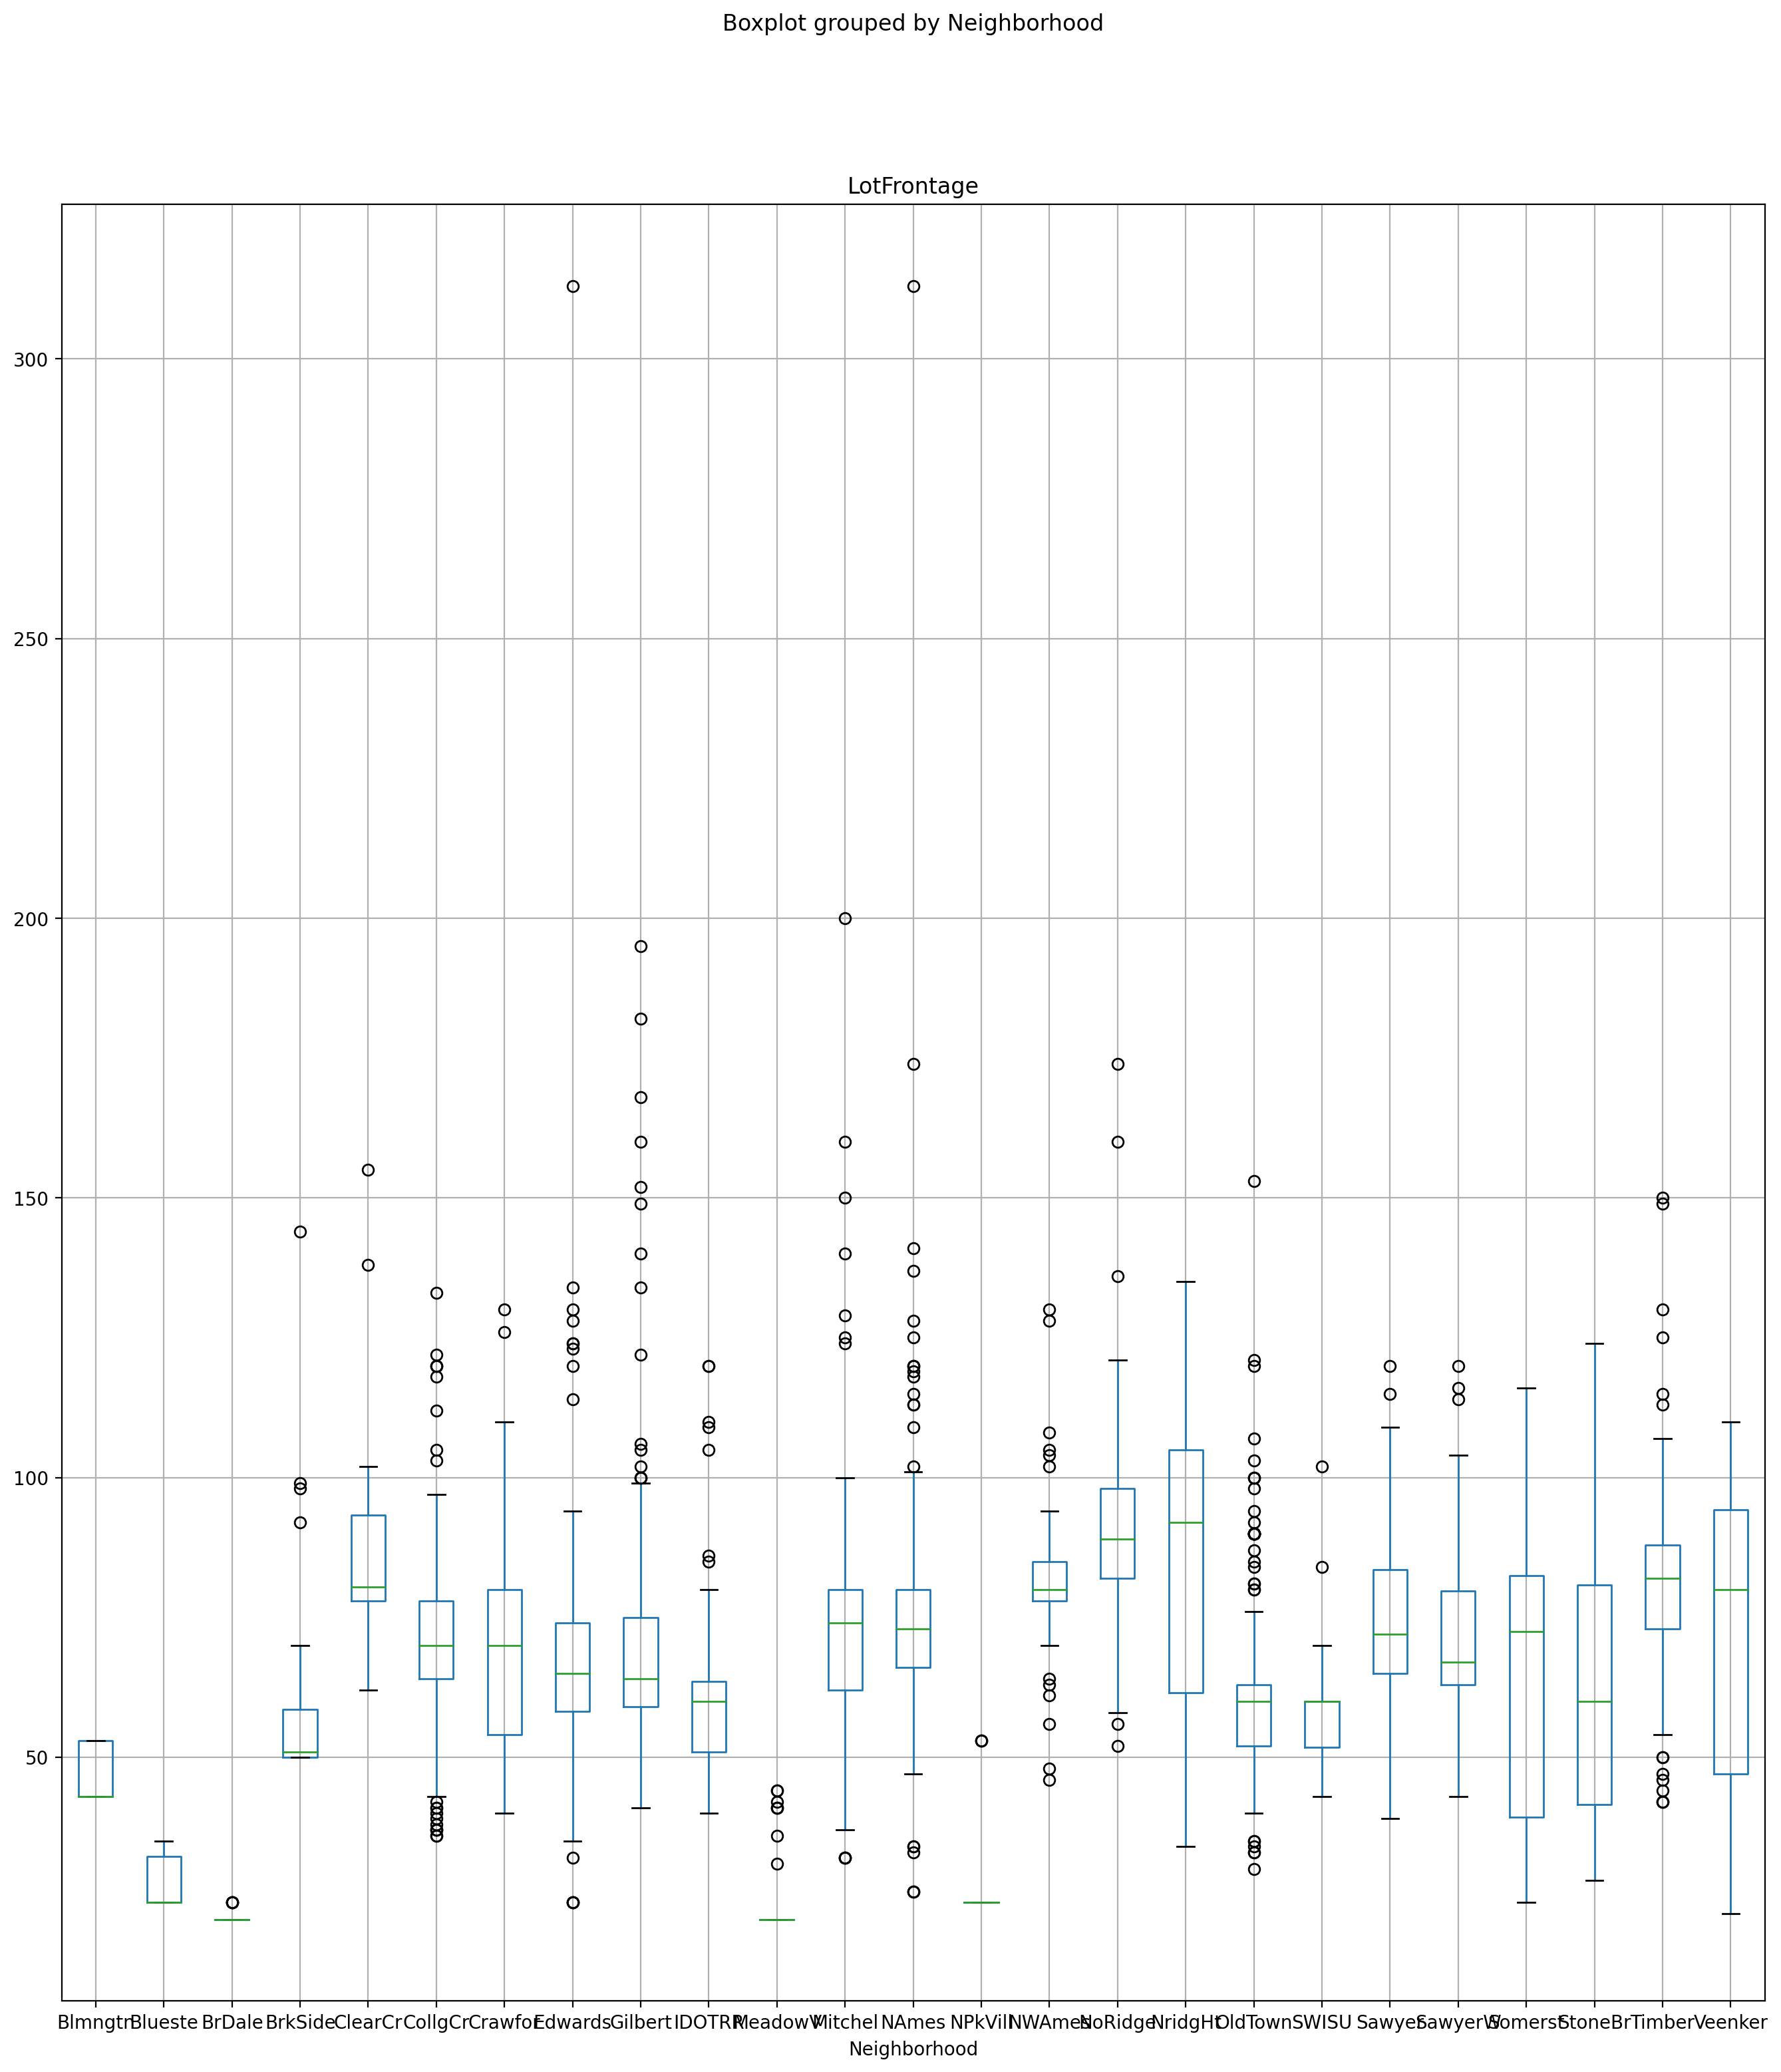

In [57]:
glob_lf.boxplot(column = 'LotFrontage', by= 'Neighborhood', figsize = (16,18));
print(glob_lf.groupby('Neighborhood')['LotFrontage'].describe())

In [58]:
# consider 2 the most significant outliers
glob_lf.LotFrontage.sort_values()
print(train.iloc[[934, 1298]][['LotFrontage', 'LotArea', 'LotShape', 'LotConfig', 'SalePrice' ]])
train.SalePrice.describe()

      LotFrontage  LotArea LotShape LotConfig  SalePrice
934         313.0    27650      IR2    Inside     242000
1298        313.0    63887      IR3    Corner     160000


count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [59]:
# we may see, that only LotFrontage doesn't influence the SalePrice dramatically, so it's reasonable to drop these 2 observations
#X = X.drop([934, 1298], axis = 0)
#num = num.drop([934, 1298], axis = 0)
#glob_lf = glob_lf.drop([934, 1298], axis = 0)
#y = y.drop([934, 1298], axis = 0)

              count       mean        std   min    25%   50%     75%    max
Neighborhood                                                               
Blmngtn        20.0  46.900000   4.919350  43.0  43.00  43.0   53.00   53.0
Blueste        10.0  27.300000   5.313505  24.0  24.00  24.0   32.25   35.0
BrDale         30.0  21.500000   1.137147  21.0  21.00  21.0   21.00   24.0
BrkSide        95.0  55.789474  12.722818  50.0  50.00  51.0   58.50  144.0
ClearCr        20.0  88.150000  22.628057  62.0  78.00  80.5   93.25  155.0
CollgCr       220.0  71.336364  15.940401  36.0  64.00  70.0   78.00  133.0
Crawfor        83.0  69.951807  19.141262  40.0  54.00  70.0   80.00  130.0
Edwards       178.0  66.910112  26.372019  24.0  58.25  65.0   74.00  313.0
Gilbert       111.0  74.207207  28.386654  41.0  59.00  64.0   75.00  195.0
IDOTRR         87.0  62.241379  15.454333  40.0  51.00  60.0   63.50  120.0
MeadowV        33.0  25.606061   8.521808  21.0  21.00  21.0   21.00   44.0
Mitchel     

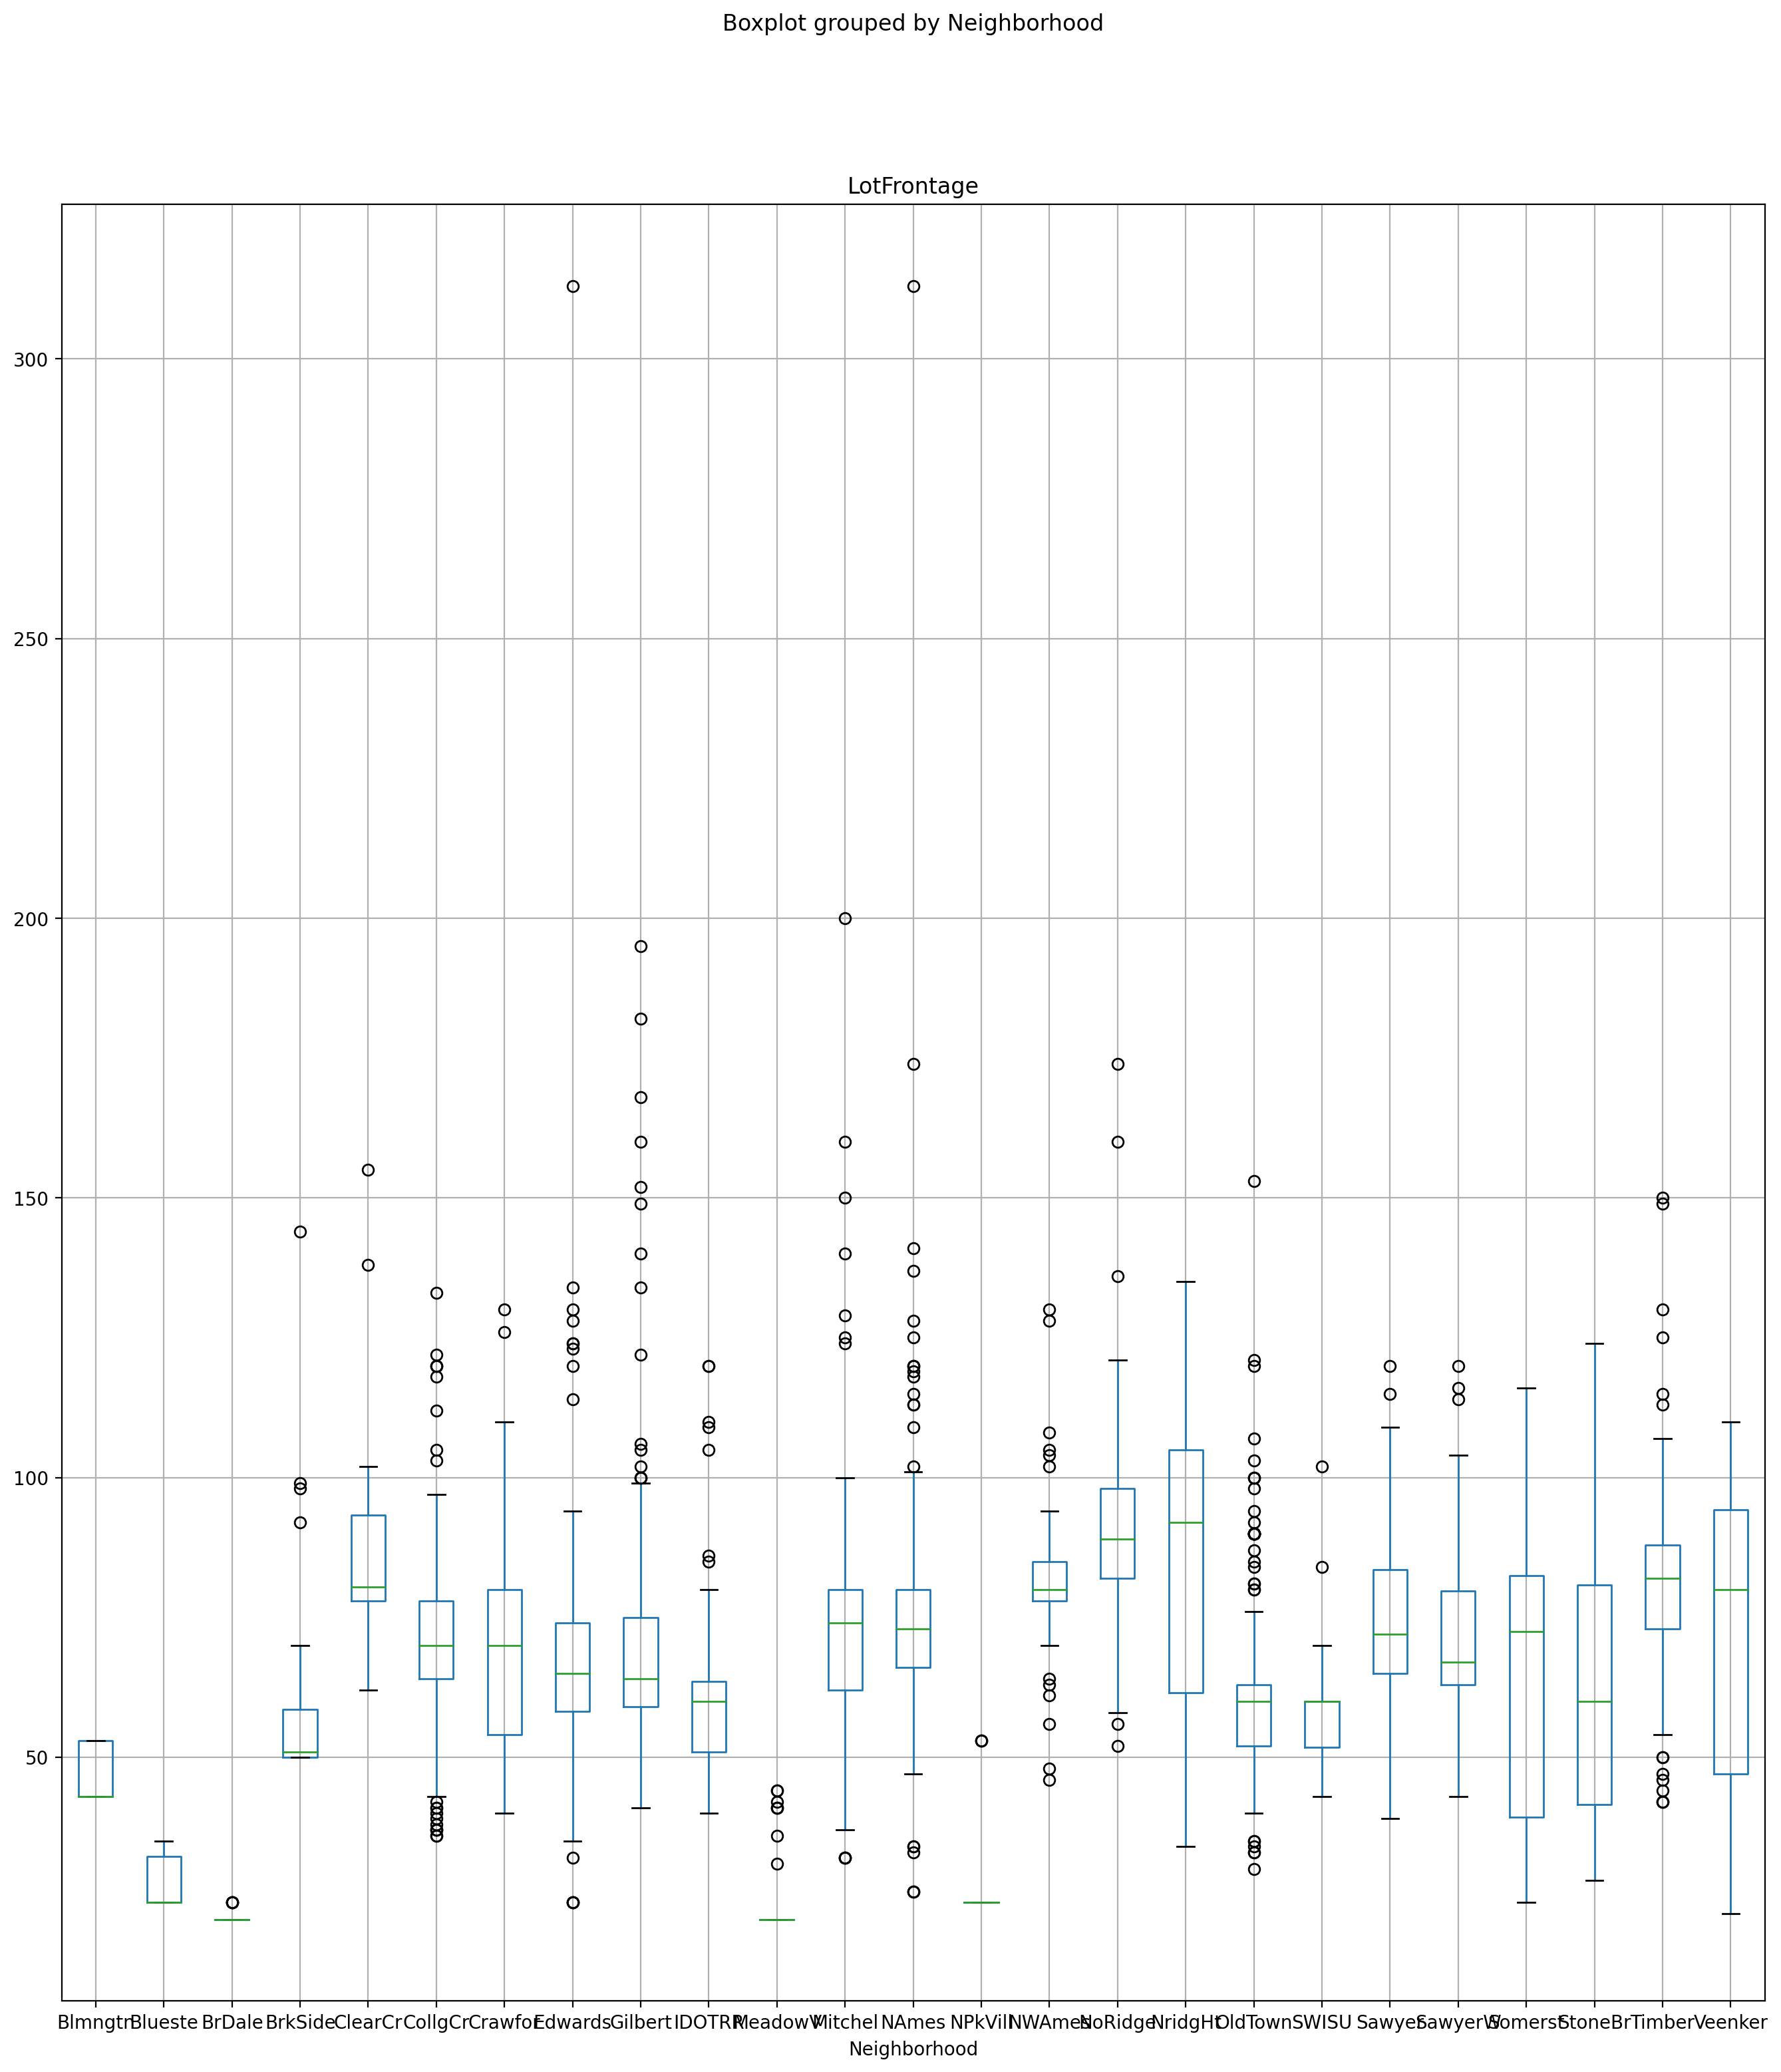

In [60]:
glob_lf.boxplot(column = 'LotFrontage', by= 'Neighborhood', figsize = (16,18));
print(glob_lf.groupby('Neighborhood')['LotFrontage'].describe())

In [61]:
#RandomForest for LotFrontage Imputation
# labels are the values we want to predict
labels = glob_lf.LotFrontage
features = glob_lf.drop('LotFrontage', axis = 1)
feature_list = list(features.columns)

In [62]:
#HotEncoding
# We have 3 categorical features: Neighborhood, LotShape and LotConfig. Transform them into dummy_type
def transformation(df):
    df = df.reset_index(drop=True)
    ohe = OneHotEncoder(handle_unknown = 'ignore')
    cat = df.select_dtypes(include=['object'])
    num = df.select_dtypes(exclude='object')
    cat_names = list(cat.columns)
    ohe.fit(cat)
    cat_enc = ohe.transform(cat).toarray()
    cat_names = ohe.get_feature_names(cat_names)
    df = pd.concat([num, 
              pd.DataFrame(cat_enc,columns=cat_names).astype('int')], axis=1)
    return df

In [63]:
features = transformation(features)
print(features)

      LotArea  Neighborhood_Blmngtn  Neighborhood_Blueste  \
0        8450                     0                     0   
1        9600                     0                     0   
2       11250                     0                     0   
3        9550                     0                     0   
4       14260                     0                     0   
...       ...                   ...                   ...   
2428     1936                     0                     0   
2429     1894                     0                     0   
2430    20000                     0                     0   
2431    10441                     0                     0   
2432     9627                     0                     0   

      Neighborhood_BrDale  Neighborhood_BrkSide  Neighborhood_ClearCr  \
0                       0                     0                     0   
1                       0                     0                     0   
2                       0                     0 

In [64]:
# split data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)
print('Training X Shape:', train_features.shape)
print('Training y Shape:', test_features.shape)
print('Testing X Shape:', train_labels.shape)
print('Testing y Shape:', test_labels.shape)

Training X Shape: (1824, 35)
Training y Shape: (609, 35)
Testing X Shape: (1824,)
Testing y Shape: (609,)


In [65]:
# establish baseline (replacement with Median or Mode)
glob_lf['Mode'] = glob_lf.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.value_counts().index[0])
glob_lf['Median'] = glob_lf.groupby('Neighborhood')['LotFrontage'].transform('median')
Mode_errors = np.round(mean_absolute_error(glob_lf['LotFrontage'], glob_lf['Mode']),2)
Median_errors = np.round(mean_absolute_error(glob_lf['LotFrontage'], glob_lf['Median']),2)
print(Mode_errors)
print(Median_errors)
# Our baseline error = 12.24

14.07
12.42


In [66]:
# train model
rf_lot = RandomForestRegressor(random_state = 42, criterion = 'mae')

In [67]:
params_lot = { 
    'n_estimators': [200, 500, 1000, 1500],
    }

kfold = KFold(n_splits= 10 , shuffle=True)

rf = GridSearchCV(estimator = rf_lot, param_grid=params_lot,cv = kfold, scoring = 'neg_mean_absolute_error', 
                 verbose = 2, refit=True)  

In [68]:
rf.fit(train_features, train_labels);

Fitting 10 folds for each of 4 candidates, totalling 40 fits
[CV] END ...................................n_estimators=200; total time=  22.8s
[CV] END ...................................n_estimators=200; total time=  23.7s
[CV] END ...................................n_estimators=200; total time=  24.8s
[CV] END ...................................n_estimators=200; total time=  21.0s
[CV] END ...................................n_estimators=200; total time=  19.4s
[CV] END ...................................n_estimators=200; total time=  21.9s
[CV] END ...................................n_estimators=200; total time=  19.8s
[CV] END ...................................n_estimators=200; total time=  21.6s
[CV] END ...................................n_estimators=200; total time=  21.6s
[CV] END ...................................n_estimators=200; total time=  20.3s
[CV] END ...................................n_estimators=500; total time=  51.5s
[CV] END ...................................n_es

In [69]:
# make predictions
predictions = rf.predict(test_features)
# we have many outliers, so it's better to use MAE as a metrics
MAE =  np.round(mean_absolute_error(predictions, test_labels),2)
print('RF MAE: ', MAE)
# Our mean absolute error = 8.73, it is better than Median error

RF MAE:  9.04


In [75]:
# function for compare cats in train and test
lf_test_features_X = X[X.LotFrontage.isna()][['Neighborhood', 'LotArea', 'LotShape', 'LotConfig']] 
def compare_cat(df1, df2):
    diff = []
    for col in df1:
        diff.extend([str(col) + '_' + str(x) for x in df2[col].unique() if x not in df1[col].unique()])
    return diff

In [76]:
# compare the number of categories in X and train_features
d1 = lf_test_features_X[['Neighborhood', 'LotShape', 'LotConfig']]
d2 = glob_lf[['Neighborhood', 'LotShape', 'LotConfig']]
diff = compare_cat(d1, d2)
print(diff)
# We may see, that in test sample we don't have BrDale and Blueste Neighborhhood and FR3 LotConfig. We need to add these columns with zero values after transformation
lf_test_features_X = transformation(lf_test_features_X)
# add missed categories to X:
lf_test_features_X = pd.concat([lf_test_features_X, pd.DataFrame(0, index=np.arange(len(lf_test_features_X)), columns = diff)], axis = 1)    
lf_test_features_X = lf_test_features_X.reindex(train_features.columns, axis=1)
# replace our LotFrontage missing values using random forest model
lf_pred_X = rf.predict(lf_test_features_X)
X.loc[X.LotFrontage.isna(), 'LotFrontage'] = lf_pred_X
num.loc[num.LotFrontage.isna(), 'LotFrontage'] = lf_pred_X

['Neighborhood_BrDale', 'Neighborhood_Blueste', 'LotConfig_FR3']


In [77]:
# do the same for test
lf_test_features_test = test[test.LotFrontage.isna()][['Neighborhood', 'LotArea', 'LotShape', 'LotConfig']] 
d3 = lf_test_features_test[['Neighborhood', 'LotShape', 'LotConfig']]
diff = compare_cat(d3, d2)
lf_test_features_test = transformation(lf_test_features_test)
lf_test_features_test = pd.concat([lf_test_features_test, pd.DataFrame(0, index=np.arange(len(lf_test_features_test)), columns = diff)], axis = 1)   
lf_test_features_test = lf_test_features_test.reindex(test_features.columns, axis=1)
lf_pred_test = rf.predict(lf_test_features_test)
test.loc[test.LotFrontage.isna(), 'LotFrontage'] = lf_pred_test
num_test.loc[num_test.LotFrontage.isna(), 'LotFrontage'] = lf_pred_test

In [78]:
print(num.isna().sum())
print(num_test.isna().sum())

Id               0
LotFrontage      0
LotArea          0
MasVnrArea       0
BsmtFinSF1       0
BsmtFinSF2       0
BsmtUnfSF        0
TotalBsmtSF      0
1stFlrSF         0
2ndFlrSF         0
LowQualFinSF     0
GrLivArea        0
BsmtFullBath     0
BsmtHalfBath     0
FullBath         0
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr     0
TotRmsAbvGrd     0
Fireplaces       0
GarageCars       0
GarageArea       0
WoodDeckSF       0
OpenPorchSF      0
EnclosedPorch    0
3SsnPorch        0
ScreenPorch      0
PoolArea         0
MiscVal          0
MoSold           0
YrSold           0
Garage_age       0
House_age        0
Remod_age        0
dtype: int64
Id               0
LotFrontage      0
LotArea          0
MasVnrArea       0
BsmtFinSF1       0
BsmtFinSF2       0
BsmtUnfSF        0
TotalBsmtSF      0
1stFlrSF         0
2ndFlrSF         0
LowQualFinSF     0
GrLivArea        0
BsmtFullBath     0
BsmtHalfBath     0
FullBath         0
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr     0

In [79]:
#################################################################
#Dimensionality Reduction
#################################################################

In [80]:
num.var().sort_values()

KitchenAbvGr     4.854892e-02
BsmtHalfBath     5.700283e-02
HalfBath         2.528937e-01
BsmtFullBath     2.692682e-01
FullBath         3.035082e-01
Fireplaces       4.155947e-01
GarageCars       5.584797e-01
BedroomAbvGr     6.654938e-01
YrSold           1.763837e+00
TotRmsAbvGrd     2.641903e+00
MoSold           7.309595e+00
Remod_age        4.260366e+02
LotFrontage      5.765501e+02
Garage_age       6.944985e+02
3SsnPorch        8.595059e+02
House_age        9.150717e+02
PoolArea         1.614216e+03
LowQualFinSF     2.364204e+03
ScreenPorch      3.108889e+03
EnclosedPorch    3.735550e+03
OpenPorchSF      4.389861e+03
WoodDeckSF       1.570981e+04
BsmtFinSF2       2.602391e+04
MasVnrArea       3.267204e+04
GarageArea       4.571251e+04
1stFlrSF         1.494501e+05
Id               1.777550e+05
2ndFlrSF         1.905571e+05
TotalBsmtSF      1.924624e+05
BsmtUnfSF        1.952464e+05
BsmtFinSF1       2.080255e+05
MiscVal          2.461381e+05
GrLivArea        2.761296e+05
LotArea   

In [81]:
# check the variance
num.describe()
# The feautures with the lowest variance are discrete (just quantity of rooms), they are relevant, so we will not drop them.

,Id,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,Garage_age,House_age,Remod_age
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,70.439586,10516.828082,103.339726,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,31.308219,36.547945,22.950000
std,421.610009,24.011458,9981.264932,180.754082,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,26.353339,30.250152,20.640653
min,1.000000,21.000000,1300.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,0.000000,0.000000,-1.000000
25%,365.750000,59.000000,7553.500000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,7.000000,8.000000,4.000000
50%,730.500000,70.000000,9478.500000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,30.000000,35.000000,14.000000
75%,1095.250000,80.000000,11601.500000,165.250000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,49.000000,54.000000,41.000000
max,1460.000000,313.000000,215245.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,136.000000,136.000000,60.000000


In [82]:
# check the correlation
corr = num.loc[:, num.columns != 'Id'].corr().unstack()
thresh = 0.5
corr_filt = corr[((corr>thresh) | (corr<-thresh)) & (corr < 1.0)].reset_index()
corr_filt.iloc[corr_filt[['level_0','level_1']].apply(lambda r: ''.join(map(str, sorted(r))), axis = 1).drop_duplicates().index]

,level_0,level_1,0
0,BsmtFinSF1,TotalBsmtSF,0.522396
1,BsmtFinSF1,BsmtFullBath,0.649212
3,TotalBsmtSF,1stFlrSF,0.819530
5,1stFlrSF,GrLivArea,0.566024
6,2ndFlrSF,GrLivArea,0.687501
7,2ndFlrSF,HalfBath,0.609707
8,2ndFlrSF,BedroomAbvGr,0.502901
9,2ndFlrSF,TotRmsAbvGrd,0.616423
12,GrLivArea,FullBath,0.630012
13,GrLivArea,BedroomAbvGr,0.521270


In [83]:
# Pair TotalBsmtSF - 1stFlrSF: basement square feet and first square feet are correlated positevely very strong. So, we can leave only TotalBsmtSF  feature.
# The feauture GrLivArea is the sum of 2 features: 1stFlrSF and 2ndFlrSF. Besides, it's correlated with total number of rooms. So, we leave only most common feature, GrLivArea .
# Garage cars - garage area: leave only GarageArea
# Garage_age - House_age: leave only House_age

In [84]:
X = X.drop(['1stFlrSF', '2ndFlrSF', 'TotRmsAbvGrd', 'GarageCars'], 1)
num = num.drop(['1stFlrSF', '2ndFlrSF', 'TotRmsAbvGrd', 'GarageCars'], 1)
test = test.drop(['1stFlrSF', '2ndFlrSF', 'TotRmsAbvGrd', 'GarageCars'], 1)
num_test = num_test.drop(['1stFlrSF', '2ndFlrSF', 'TotRmsAbvGrd', 'GarageCars'], 1)

In [ ]:
#################################################################
#Final Model
#################################################################

In [85]:
# Concat cat, num, and dum:
X_final = pd.concat([cat, dum, num], axis=1)
test_final = pd.concat([cat_test, dum_test, num_test], axis=1)

In [86]:
train_X, test_X, train_y, test_y = train_test_split(X_final, y, test_size = 0.25, random_state = 42)

In [92]:
xg_f = xg.XGBRegressor(random_state = 42, eval_metric = 'mae')

In [93]:
params1={"eta": (0.05, 0.10, 0.15),
                        "max_depth": [ 3, 4, 5, 6, 8],
                        "min_child_weight": [ 1, 3, 5, 7],
                        "gamma":[ 0.0, 0.1, 0.2],
                        "colsample_bytree":[ 0.3, 0.4, 0.5, 0.6, 0.7, 0.7, 0.8, 0.9, 1]}

In [94]:
kfold1 = KFold(n_splits=5, shuffle=True, random_state=42)

xg_final = RandomizedSearchCV(xg_f, 
                         param_distributions = params1,
                         cv = kfold1,  
                         n_iter = 50,
                         scoring='neg_mean_absolute_error', 
                         verbose = 2, 
                         n_jobs = -1,
                        refit=True)

In [95]:
xg_final.fit(train_X, train_y)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          eval_metric='mae', gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weigh...
                                          random_state=42, reg_alpha=None,
                                          reg_lambda=None,
                                          scale_pos_weight=None, subsample=None,
                  

In [96]:
y_pred_xg = xg_final.predict(test_X)
predictions_xg = [round(value) for value in y_pred_xg]
MAE_xg_f = np.round(mean_absolute_error(test_y, predictions_xg),2)
print('XG MAE: ', MAE_xg_f)

XG MAE:  15912.64


In [97]:
sub = xg_final.predict(test_final)
submission = pd.concat([test['Id'], pd.DataFrame(sub)], axis=1)
submission.columns = ['Id', 'SalePrice']
print(submission)

        Id      SalePrice
0     1461  117035.101562
1     1462  147744.015625
2     1463  173461.250000
3     1464  179027.437500
4     1465  186853.062500
...    ...            ...
1454  2915   84915.203125
1455  2916   83244.960938
1456  2917  147471.546875
1457  2918  122473.289062
1458  2919  201438.500000

[1459 rows x 2 columns]


In [98]:
submission.to_csv("Housing_sub2.csv", index = False)

In [99]:
################################################
# FINAL SCORE = 0.13986
################################################